In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, BooleanType, IntegerType

In [2]:
path2openAIRE = "/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/"
path2S2 = "/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet/"
path2PATSTAT = "/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/"
path2cordis = "/export/ml4ds/IntelComp/Datalake/CORDIS/20230823/parquet/"

# 1. Cancer

## 1.1. Definition of the target datasets

### 1.1.1. Publications

HCERES has provided a closed list of publications for inclusion in the dataset:

In [3]:
cancer_PMID_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PMID_Cancer.parquet"
cancer_PMID = spark.read.parquet(cancer_PMID_file).cache()
print('Number of provided publications in the cancer domain:', cancer_PMID.count())
cancer_PMID.show(n=2, truncate=120, vertical=True)

Number of provided publications in the cancer domain: 2438253
-RECORD 0--------
 PMID | 10725091 
-RECORD 1--------
 PMID | 10725105 
only showing top 2 rows



In [6]:
# Matching with Semantic Scholar publications

papers_S2 = spark.read.parquet(path2S2 + "papers.parquet")
col_to_keep = ["id", "pmid", "doi", "year", "title", "paperAbstract"]
papers_S2 = papers_S2.select(*col_to_keep).cache()

cancer_S2 = cancer_PMID.join(papers_S2, cancer_PMID.PMID == papers_S2.pmid, how='inner').drop("PMID").cache()
print('Number of cancer publications in Semantic Scholar:', cancer_S2.count())
print('Number of cancer publications in Semantic Scholar with non null abstract:', cancer_S2.filter(F.col("paperAbstract").isNotNull()).count())

Number of cancer publications in Semantic Scholar: 2436965
Number of cancer publications in Semantic Scholar with non null abstract: 1522138


In [7]:
cancer_S2_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/S2_Cancer.parquet"
cancer_S2.write.parquet(cancer_S2_file)

In [4]:
# Matching with OpenAIRE publications

result_instance_pid = spark.read.parquet(path2openAIRE + "result_instance_pid")
result_pmid = result_instance_pid.filter(result_instance_pid["type"] == "PubMed ID")
col_to_keep = ["result", "pid"]
result_pmid = result_pmid.select(*col_to_keep).withColumnRenamed("result","id").withColumnRenamed("pid","pmid").dropDuplicates()

cancer_OA = cancer_PMID.join(result_pmid, cancer_PMID.PMID == result_pmid.pmid, how="inner").drop("PMID").cache()
print('Number of cancer publications in OpenAire:', cancer_OA.count())

23/08/29 02:32:50 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


Number of cancer publications in OpenAire: 2393228


In [5]:
result_titles = spark.read.parquet(path2openAIRE + "result_titles").dropDuplicates(subset=["id"])
cancer_OA = cancer_OA.join(result_titles, on="id", how="left").drop(result_titles.id)

In [6]:
result_description = spark.read.parquet(path2openAIRE + "result_description").dropDuplicates(subset=["id"])
cancer_OA = cancer_OA.join(result_description, on="id", how="left").drop(result_description.id).cache()

In [7]:
print('Number of cancer publications in OpenAIRE with non null abstract:', cancer_OA.filter(F.col("description").isNotNull()).count())

Number of cancer publications in OpenAIRE with non null abstract: 2329760


In [8]:
cancer_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/OA_Cancer.parquet"
cancer_OA.write.parquet(cancer_OA_file)

In [9]:
cancer_OA.show(n=2, truncate=120, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------
 id          | doi_dedup___::000e32b41396c454e9d665a32c959feb                                                                           
 title       | Long-Term Laryngeal Allograft Survival Using Low-Dose Everolimus                                                         
 description | Abstract   Objective  The purpose of this study was to explore the mechanism and utility of everolimus as a single-ag... 
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------
 id          | doi_dedup___::000e600156867c15e1ab7adbabd38b3f                                                                           
 title       | The cost-saving effect of centralized histological reviews with soft tissue and visceral sarcomas, GIST, and desmoid ... 
 description | Objective   This study exa

### 1.1.2. Patents

In [9]:
query = "select appln_id, docdb_family_id, appln_title, appln_title_lg, appln_abstract, appln_abstract_lg, appln_filing_year, earliest_filing_year, "
query += "granted, appln_auth, receiving_office, ipr_type from parquet.`" + path2PATSTAT + "/patstat_appln.parquet`"
df_patents = spark.sql(query)

df_patents = df_patents.filter(F.col("appln_abstract").isNotNull()).filter(df_patents.appln_abstract_lg=="en").cache()

print('Number of patents with abstract in English language:', df_patents.count())
df_patents.printSchema()
df_patents.show(n=2, truncate=120, vertical=True)

23/08/30 11:25:32 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of patents with abstract in English language: 75348760
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10000172                                                                                                                 
 docdb_family_id      | 5871993                                                                    

#### 1.1.2.1. Filtering according to CPC

HCERES has provided a list of CPC codes related to cancer. We will use them to retrieve a first series of patents.

In [4]:
query = "select appln_id, cpc_class_symbol from parquet.`" + path2PATSTAT + "tls224.parquet`"
df_cpc = spark.sql(query)

print('Number of cpc entries:', df_cpc.count())
df_cpc.printSchema()
df_cpc.show(n=2, truncate=120, vertical=True)

23/08/30 11:13:59 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of cpc entries: 372088875
root
 |-- appln_id: string (nullable = true)
 |-- cpc_class_symbol: string (nullable = true)

-RECORD 0-----------------------
 appln_id         | 26591291    
 cpc_class_symbol | C22C  18/04 
-RECORD 1-----------------------
 appln_id         | 26591291    
 cpc_class_symbol | H01M   4/42 
only showing top 2 rows



In [7]:
cancer_cpcs = ["C12Q1/6886","G01N33/574","A61K39/0011","G01N33/5011","G01N33/57484","C07K16/30","G01N33/57492","A61L2300/416","G01N33/57434","G01N33/53","G01N33/57423","G01N33/57419","G01N33/57415","G01N33/57407","G01N33/57488","C12N15/1135","A61K47/48569","G01N33/57438","G06T2207/30096","G01N33/57496","G01N33/57426","C07K16/3053","C07K16/3069","G01N33/57449","C12N5/0693","A23V2200/308","C07K16/3015","A61K47/48584","C07K16/3007","C07K16/3046","C07K16/3061","G01N33/57446","A61K2039/5152","A61K2039/585","C07K16/303","A61K51/1045","G01N2800/7028","G01N33/5743","A61K35/13","A61K47/48638","C07K16/3023","G01N33/5017","G01N33/5748","A61K35/768","A61K47/4863","G01N2333/82","G01N33/57411","C07K16/3076","A61K47/48615","G01N33/57442","Y10S436/813","A61K47/48576","A61K51/1072","C07K16/3038","A61K51/1057","A61K51/1048","C12N5/0093","A61K47/48607","Y10S977/911","A61K38/1764","G01N33/57476","G01N33/57469","A61K51/106","A61K45/05","G01N2033/57403","G01N2033/57461","G01N2033/57465","G01N2033/57453","G01N2033/57457"]
CPC_match_UDF = F.udf(lambda x: x.replace(' ', '') in cancer_cpcs, BooleanType())

# df_FOS.withColumn("FOS_source", myUDF(F.col("S2fieldsofstudy"))) \
#   .show(n=2, truncate=120, vertical=True)

df_cpc_cancer = df_cpc.withColumn("isCancer", CPC_match_UDF(F.col("cpc_class_symbol"))).filter("isCancer").drop("isCancer").cache()

print('Number of cpc entries:', df_cpc_cancer.count())

df_appln_cancer = df_cpc_cancer.groupBy("appln_id").agg(F.collect_list("cpc_class_symbol").alias("cpc_class_symbol"))

print('Number of applications:', df_appln_cancer.count())
df_appln_cancer.printSchema()
df_appln_cancer.show(n=2, truncate=120, vertical=True)

Number of cpc entries: 460673


Number of applications: 293084
root
 |-- appln_id: string (nullable = true)
 |-- cpc_class_symbol: array (nullable = false)
 |    |-- element: string (containsNull = false)



-RECORD 0----------------------------
 appln_id         | 10007045         
 cpc_class_symbol | [C12N   5/0693]  
-RECORD 1----------------------------
 appln_id         | 1001853          
 cpc_class_symbol | [G01N  33/57434] 
only showing top 2 rows



In [10]:
selected_CPC = df_patents.join(df_appln_cancer, df_patents.appln_id == df_appln_cancer.appln_id, "inner").drop(df_appln_cancer.appln_id)
print('Selected CPC:', selected_CPC.count())
selected_CPC.printSchema()
selected_CPC.show(n=2, truncate=120, vertical=True)

Selected CPC: 209547
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)
 |-- cpc_class_symbol: array (nullable = false)
 |    |-- element: string (containsNull = false)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 128357                                                                                                                   
 docdb_family_id      | 37963490                                                                                                                 
 appln_title          | CANCER IMAGING AND TREATMENT                                                                                             
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | A compound, or a pharmaceutically acceptable salt or ester thereof, comprises a ligand for the chemokine receptor CXC... 
 appln_abstract_lg    | en                                                                                                  

In [11]:
cancer_CPC_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_CPC_Cancer.parquet"

selected_CPC.repartition(40).write.parquet(cancer_CPC_file)

#### 1.1.2.2. Filtering according to Keywords

Additionally, we have a list of 123 keywords provided by HCERES that can be used for the selection of patents.

In [12]:
with open("/export/clusterdata/jarenas/Datasets/patstat/2023_Spring/Cancer_keywords_HCERES_patents.txt", "r") as fin:
    Cancer_kwds = [el.strip() for el in fin.readlines()]
    Cancer_kwds = [el for el in Cancer_kwds if len(el)]
print('Number of keywords:', len(Cancer_kwds))

Number of keywords: 123


In [13]:
def count_kwds(x):
    try:
        reps = [x.lower().count(k) for k in Cancer_kwds]
        return sum(reps)
    except:
        return 0

count_kwds_UDF = F.udf(count_kwds, IntegerType())

Cancer_patents = df_patents.withColumn('raw_text', 
                    F.concat(F.col('appln_title'),F.lit(' '), F.col('appln_abstract')))

Cancer_patents = Cancer_patents.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
Cancer_patents = Cancer_patents.filter(Cancer_patents.Kwd_count > 0).cache()

print('Number of documents in Cancer dataset:', Cancer_patents.count())
Cancer_patents.show(n=2, truncate=120, vertical=True)

Number of documents in Cancer dataset: 580280
-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 108231                                                                                                                   
 docdb_family_id      | 40263006                                                                                                                 
 appln_title          | RNAI-RELATED INHIBITION OF TNFA SIGNALING PATHWAY FOR TREATMENT OF OCULAR ANGIOGENESIS                                   
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | RNA interference is provided for inhibition of tumor necrosis factor (TNF ) by silencing TNF cell surface receptor TN... 
 appln_abstract_lg    | en                                                    

In [14]:
cancer_Kwds_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_Kwds_Cancer.parquet"

Cancer_patents.drop("raw_text").drop("Kwd_count").repartition(40).write.parquet(cancer_Kwds_file, mode="overwrite")

#### 1.1.2.3. Filtering according to citations related to Cancer

A last strategy is to select patents that include citations to papers which have been selected by HCERES

In [21]:
cancer_S2 = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/S2_Cancer.parquet')

print('Number of Cancer publications in S2:', cancer_S2.count())
cancer_S2.show(n=2, truncate=120, vertical=True)

cancer_dois = cancer_S2.filter(F.col("doi").isNotNull()).select("doi")
cancer_dois.show(n=5, truncate=120, vertical=True)
print('Number of Cancer publications with doi:', cancer_dois.count())

Number of Cancer publications in S2: 2436965


-RECORD 0---------------------------------------------------------------------------------------------------------------------------------
 id            | 19161039                                                                                                                 
 doi           | 10.1002/(SICI)1098-2264(200002)27:2<162::AID-GCC7>3.0.CO;2-9                                                             
 year          | 2000                                                                                                                     
 title         | Molecular genetic alterations in carcinoma ex‐pleomorphic adenoma: A putative progression model?                         
 paperAbstract | To determine the genetic changes associated with the development of carcinoma ex‐pleomorphic adenoma (Ca Ex‐PA), we a... 
-RECORD 1---------------------------------------------------------------------------------------------------------------------------------
 id            | 46428546  

In [22]:
query = "select appln_id, npl_doi as doi from parquet.`" + path2PATSTAT + "npl_citations.parquet`"
citations = spark.sql(query)
citations.count()

23/08/30 11:58:08 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


71450314

In [23]:
citations = citations.filter(F.col("doi").isNotNull())
print(citations.count())

1938151


In [25]:
intersect = citations.join(cancer_dois, citations.doi==cancer_dois.doi, "inner")
print(intersect.count())

159038


In [27]:
patents_cancer_npl = intersect.select("appln_id").distinct()
patents_cancer_npl.count()

77789

In [28]:
patents_cancer_npl.show(n=5, truncate=120, vertical=True)

-RECORD 0-------------
 appln_id | 407079753 
-RECORD 1-------------
 appln_id | 539836071 
-RECORD 2-------------
 appln_id | 538573027 
-RECORD 3-------------
 appln_id | 522657239 
-RECORD 4-------------
 appln_id | 479356246 
only showing top 5 rows



In [32]:
selected_publis = df_patents.join(patents_cancer_npl, on = "appln_id", how = "inner").drop(patents_cancer_npl.appln_id)
print('Selected publis:', selected_publis.count())
selected_publis.printSchema()
selected_publis.show(n=2, truncate=120, vertical=True)

Selected publis: 75128
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 16257674                                                                                                                 
 docdb_family_id      | 40262947                                                                                                                 
 appln_title          | PREPRIMITIVE STREAK AND MESENDODERM CELLS                                                                                
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | This disclosure relates to compositions comprising human preprimitive streak cells and/or human mesendoderm cells as ... 
 appln_abstract_lg    | en                                                                                                  

In [33]:
cancer_npl_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_npl_Cancer.parquet"

selected_publis.repartition(40).write.parquet(cancer_npl_file, mode="overwrite")

#### 1.1.2.4. Calculating the intersection

In [35]:
cancer_CPC = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_CPC_Cancer.parquet').drop("cpc_class_symbol")
cancer_Kwds = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_Kwds_Cancer.parquet')
cancer_npl = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_npl_Cancer.parquet')


In [38]:
df_aux = cancer_Kwds.select("appln_id")
cancer_intersection = cancer_CPC.join(df_aux, on = "appln_id", how = "inner").drop(df_aux.appln_id)
# df_aux = cancer_npl.select("appln_id")
# cancer_intersection = cancer_CPC.join(df_aux, on = "appln_id", how = "inner").drop(df_aux.appln_id)

print('Size of intersection:', cancer_intersection.count())
cancer_intersection.printSchema()
cancer_intersection.show(n=2, truncate=120, vertical=True)

Size of intersection: 131369
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 11246697                                                                                                                 
 docdb_family_id      | 6466484                                                                                                                  
 appln_title          | Isolation of circulating cancer cells from bloodstream                                                                   
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | Method (A) for isolating and culturing transformed cells circulating in the bloodstream of an individual comprises tr... 
 appln_abstract_lg    | en                                                                                                  

In [39]:
cancer_intersection_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_intersection_Cancer.parquet"

cancer_intersection.repartition(40).write.parquet(cancer_intersection_file, mode="overwrite")

#### 1.1.2.5 Calculating the union

In [44]:
cancer_all = cancer_CPC.union(cancer_Kwds).union(cancer_npl).dropDuplicates(["appln_id"])

print('Size of union:', cancer_all.count())
cancer_all.printSchema()
cancer_all.show(n=2, truncate=120, vertical=True)

Size of union: 698966
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10051360                                                                                                                 
 docdb_family_id      | 5897991                                                                                                                  
 appln_title          | Anti-cancer medicaments contg. amygdalin - causing tumour regression, preventing further tumour growth and having ana... 
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | A novel medicament for treating cancer contains amygdalin (I) as active ingredient, opt in combination with thiamine ... 
 appln_abstract_lg    | en                                                                                                  

In [45]:
cancer_all_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/PATSTAT_all_Cancer.parquet"

cancer_all.repartition(40).write.parquet(cancer_all_file, mode="overwrite")

### 1.1.3. CORDIS projects

#### 1.1.3.1. Filtering according to EuroSciVoc

A first selection of projects is based on the EuroSciVoc codes. All projects under /21/39/225 (oncology) should be selected as relevant projects for the domain.

In [13]:
projects = spark.read.parquet(path2cordis + "projects.parquet")
print('Number of projects:', projects.count())

cancer_codes = [1475, 1471, 86801484, 1469, 30053, 719, 1467, 49564263, 78799773, 1473, 30063, 1801, 30064, 1465, 225]

#Keep only projects which contain non-null euroSciVocCode field
cancer_projects = projects.filter(F.col("euroSciVocCode").isNotNull())

EVOC_match_UDF = F.udf(lambda x: len([el for el in x if el in cancer_codes]), IntegerType())

cancer_projects = cancer_projects.withColumn("isCancer", EVOC_match_UDF(F.col("euroSciVocCode")))
cancer_projects = cancer_projects.filter(cancer_projects.isCancer > 0).drop("isCancer")

print('Number of cancer projects according to EuroSciVoc:', cancer_projects.count())
cancer_projects.printSchema()
cancer_projects.show(n=2, truncate=120, vertical=True)

Number of projects: 69613


Number of cancer projects according to EuroSciVoc: 4020
root
 |-- projectID: long (nullable = true)
 |-- acronym: string (nullable = true)
 |-- status: string (nullable = true)
 |-- title: string (nullable = true)
 |-- startDate: timestamp (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- totalCost: string (nullable = true)
 |-- ecMaxContribution: string (nullable = true)
 |-- ecSignatureDate: timestamp (nullable = true)
 |-- frameworkProgramme: string (nullable = true)
 |-- masterCall: string (nullable = true)
 |-- subCall: string (nullable = true)
 |-- fundingScheme: string (nullable = true)
 |-- nature: string (nullable = true)
 |-- objective: string (nullable = true)
 |-- contentUpdateDate: timestamp (nullable = true)
 |-- rcn: long (nullable = true)
 |-- grantDoi: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- topic_title: string (nullable = true)
 |-- countryContr: string (nullable = true)
 |-- orgContr: string (nullable = true)
 |-- coordinator

In [14]:
cordis_EVOC_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_evoc_Cancer.parquet"

cancer_projects.repartition(40).write.parquet(cordis_EVOC_file)

#### 1.1.3.2. Filtering according to Keywords

Additionally, we have a list of 123 keywords provided by HCERES that can be used for the selection of patents.

In [37]:
with open("/export/clusterdata/jarenas/Datasets/patstat/2023_Spring/Cancer_keywords_HCERES_patents.txt", "r") as fin:
    Cancer_kwds = [el.strip() for el in fin.readlines()]
    Cancer_kwds = [el for el in Cancer_kwds if len(el)]
print('Number of keywords:', len(Cancer_kwds))

Number of keywords: 123


In [38]:
def count_kwds(x):
    try:
        reps = [x.lower().count(k) for k in Cancer_kwds]
        return sum(reps)
    except:
        return 0

count_kwds_UDF = F.udf(count_kwds, IntegerType())

cancer_projects = projects.withColumn('raw_text', 
                    F.concat(F.col('title'),F.lit(' '), F.col('objective')))

cancer_projects = cancer_projects.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
cancer_projects = cancer_projects.filter(cancer_projects.Kwd_count > 0).cache().drop("raw_text").drop("Kwd_count")

print('Number of projects with cancer keywords:', cancer_projects.count())
cancer_projects.show(n=2, truncate=120, vertical=True)

Number of projects with cancer keywords: 5121
-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 projectID          | 200620                                                                                                                   
 acronym            | CANCERDIP                                                                                                                
 status             | CLO                                                                                                                      
 title              | The use of Methylated DNA Immunoprecipitation MeDIP in cancer for better clinical management                             
 startDate          | 2008-01-01 00:00:00                                                                                                      
 endDate            | 2011-06-30 00:00:00                                                 

In [39]:
cordis_Kwds_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_Kwds_Cancer.parquet"

cancer_projects.repartition(40).write.parquet(cordis_Kwds_file)

#### 1.1.3.3. Filtering according to acknowledgments to Cancer publications

A last strategy is to select projects that include among their results some of the papers which have been selected by HCERES

In [18]:
cancer_S2 = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/S2_Cancer.parquet')

print('Number of Cancer publications in S2:', cancer_S2.count())
cancer_S2.show(n=2, truncate=120, vertical=True)

cancer_dois = cancer_S2.filter(F.col("doi").isNotNull()).select("doi")
cancer_dois.show(n=5, truncate=120, vertical=True)
print('Number of Cancer publications with doi:', cancer_dois.count())

Number of Cancer publications in S2: 2436965
-RECORD 0---------------------------------------------------------------------------------------------------------------------------------
 id            | 19161039                                                                                                                 
 doi           | 10.1002/(SICI)1098-2264(200002)27:2<162::AID-GCC7>3.0.CO;2-9                                                             
 year          | 2000                                                                                                                     
 title         | Molecular genetic alterations in carcinoma ex‐pleomorphic adenoma: A putative progression model?                         
 paperAbstract | To determine the genetic changes associated with the development of carcinoma ex‐pleomorphic adenoma (Ca Ex‐PA), we a... 
-RECORD 1----------------------------------------------------------------------------------------------------------------

Number of Cancer publications with doi: 2310347


In [23]:
cordis_publis = spark.read.parquet(path2cordis + "publications.parquet")

#We filter those without doi
cordis_publis = cordis_publis.filter(F.col("doi").isNotNull())
print('Number of publications with doi:', cordis_publis.count())

#We retain only the citations related to cancer
cancer_publis = cordis_publis.join(cancer_dois, on="doi", how="inner").drop(cancer_dois.doi)
print('Number of publications in the cancer dataset:', cancer_publis.count())

cancer_publis.printSchema()
cancer_publis.show(n=2, truncate=120, vertical=True)

Number of publications with doi: 626316


Number of publications in the cancer dataset: 84373
root
 |-- doi: string (nullable = true)
 |-- projectID: long (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- isPublishedAs: string (nullable = true)
 |-- repositoryUrl: string (nullable = true)
 |-- journalTitle: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- journalNumber: string (nullable = true)
 |-- publishedPages: string (nullable = true)
 |-- id: string (nullable = true)
 |-- frameworkProgramme: string (nullable = true)
 |-- publishedYear: double (nullable = true)
 |-- issn: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- projectAcronym: string (nullable = true)
 |-- collection: string (nullable = true)
 |-- contentUpdateDate: timestamp (nullable = true)
 |-- rcn: double (nullable = true)
 |-- SSID: long (nullable = true)



-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 doi                | 10.1002/adhm.201900665                                                                                                   
 projectID          | 319130                                                                                                                   
 title              | Supramolecular Toxin Complexes for Targeted Pharmacological Modulation of Polymorphonuclear Leukocyte Functions          
 authors            | Astrid Johanna Heck , Theresa Ostertag , Leonie Schnell , Stephan Fischer , Bikram Keshari Agrawalla , Pia Winterwerb... 
 isPublishedAs      | PEER_REVIEWED_ARTICLE                                                                                                    
 repositoryUrl      | https://onlinelibrary.wiley.com/doi/abs/10.1002/adhm.201900665                                                    

In [26]:
projects_publis = cancer_publis.select("projectID").distinct()
print("Number of selected projects:", projects_publis.count())

Number of selected projects: 4097


In [27]:
cancer_projects = projects.join(projects_publis, on="projectID", how="inner").drop(projects_publis.projectID)

print('Number of projects ackwnoledged by cancer papers:', cancer_projects.count())
cancer_projects.show(n=2, truncate=120, vertical=True)

Number of projects ackwnoledged by cancer papers: 4095


-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 projectID          | 223367                                                                                                                   
 acronym            | MULTIMOD                                                                                                                 
 status             | CLO                                                                                                                      
 title              | Multi-layer network modules to identify markers for personalized medication in complex diseases                          
 startDate          | 2008-11-01 00:00:00                                                                                                      
 endDate            | 2012-10-31 00:00:00                                                                                               

In [28]:
cordis_ACK_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_ACK_Cancer.parquet"

cancer_projects.repartition(40).write.parquet(cordis_ACK_file)

#### 1.1.3.4. Calculating the intersection

In [40]:
cancer_evoc = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_evoc_Cancer.parquet')
cancer_Kwds = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_Kwds_Cancer.parquet')
cancer_ACK = spark.read.parquet('file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_ACK_Cancer.parquet')

In [32]:
df_aux = cancer_Kwds.select("projectID")
cancer_intersection = cancer_evoc.join(df_aux, on = "projectID", how = "inner").drop(df_aux.projectID)
df_aux = cancer_ACK.select("projectID")
cancer_intersection = cancer_intersection.join(df_aux, on = "projectID", how = "inner").drop(df_aux.projectID)

print('Size of intersection:', cancer_intersection.count())
cancer_intersection.printSchema()
cancer_intersection.show(n=2, truncate=120, vertical=True)

Size of intersection: 1308
root
 |-- projectID: long (nullable = true)
 |-- acronym: string (nullable = true)
 |-- status: string (nullable = true)
 |-- title: string (nullable = true)
 |-- startDate: timestamp (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- totalCost: string (nullable = true)
 |-- ecMaxContribution: string (nullable = true)
 |-- ecSignatureDate: timestamp (nullable = true)
 |-- frameworkProgramme: string (nullable = true)
 |-- masterCall: string (nullable = true)
 |-- subCall: string (nullable = true)
 |-- fundingScheme: string (nullable = true)
 |-- nature: string (nullable = true)
 |-- objective: string (nullable = true)
 |-- contentUpdateDate: timestamp (nullable = true)
 |-- rcn: long (nullable = true)
 |-- grantDoi: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- topic_title: string (nullable = true)
 |-- countryContr: string (nullable = true)
 |-- orgContr: string (nullable = true)
 |-- coordinatorCountry: string (nullable = t

In [33]:
cancer_intersection_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_intersection_Cancer.parquet"

cancer_intersection.repartition(40).write.parquet(cancer_intersection_file)

#### 1.1.3.5. Calculating the union

In [41]:
cancer_all = cancer_evoc.union(cancer_Kwds).union(cancer_ACK).dropDuplicates(["projectID"])

print('Size of union:', cancer_all.count())
cancer_all.printSchema()
cancer_all.show(n=2, truncate=120, vertical=True)

Size of union: 7722
root
 |-- projectID: long (nullable = true)
 |-- acronym: string (nullable = true)
 |-- status: string (nullable = true)
 |-- title: string (nullable = true)
 |-- startDate: timestamp (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- totalCost: string (nullable = true)
 |-- ecMaxContribution: string (nullable = true)
 |-- ecSignatureDate: timestamp (nullable = true)
 |-- frameworkProgramme: string (nullable = true)
 |-- masterCall: string (nullable = true)
 |-- subCall: string (nullable = true)
 |-- fundingScheme: string (nullable = true)
 |-- nature: string (nullable = true)
 |-- objective: string (nullable = true)
 |-- contentUpdateDate: timestamp (nullable = true)
 |-- rcn: long (nullable = true)
 |-- grantDoi: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- topic_title: string (nullable = true)
 |-- countryContr: string (nullable = true)
 |-- orgContr: string (nullable = true)
 |-- coordinatorCountry: string (nullable = true)
 |

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 projectID          | 115153                                                                                                                   
 acronym            | RAPP-ID                                                                                                                  
 status             | ONG                                                                                                                      
 title              | Development of RApid Point-of-Care test Platforms for Infectious Diseases                                                
 startDate          | 2011-04-01 00:00:00                                                                                                      
 endDate            | 2016-09-30 00:00:00                                                                                               

root
 |-- projectID: long (nullable = true)
 |-- acronym: string (nullable = true)
 |-- status: string (nullable = true)
 |-- title: string (nullable = true)
 |-- startDate: timestamp (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- totalCost: string (nullable = true)
 |-- ecMaxContribution: string (nullable = true)
 |-- ecSignatureDate: timestamp (nullable = true)
 |-- frameworkProgramme: string (nullable = true)
 |-- masterCall: string (nullable = true)
 |-- subCall: string (nullable = true)
 |-- fundingScheme: string (nullable = true)
 |-- nature: string (nullable = true)
 |-- objective: string (nullable = true)
 |-- contentUpdateDate: timestamp (nullable = true)
 |-- rcn: long (nullable = true)
 |-- grantDoi: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- topic_title: string (nullable = true)
 |-- countryContr: string (nullable = true)
 |-- orgContr: string (nullable = true)
 |-- coordinatorCountry: string (nullable = true)
 |-- coordinatorOrg: d

In [42]:
cancer_all_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/cancer/cordis_all_Cancer.parquet"

cancer_all.repartition(40).write.parquet(cancer_all_file)

# 2. Artificial Intelligence (Kwds only)

In all cases, matches in this domain are started with a series of AI specific keywords

In [3]:
with open("/export/data_ml4ds/IntelComp/Datasets/semanticscholar/20230418/IA_keywords_SEAD_REV_JAG_JCS.txt", "r") as fin:
    AI_kwds = [el.strip() for el in fin.readlines()]
    AI_kwds = [el for el in AI_kwds if len(el)]
print('Number of keywords:', len(AI_kwds))

Number of keywords: 266


## 2.1. Domain Selection

### 2.1.1 Publications

#### 2.1.1.1. Semantic Scholar

In [5]:
# Matching with Semantic Scholar publications

papers_S2 = spark.read.parquet(path2S2 + "papers.parquet")
col_to_keep = ["id", "pmid", "doi", "year", "title", "paperAbstract"]
papers_S2 = papers_S2.select(*col_to_keep).cache()

def count_kwds(x):
    try:
        reps = [x.lower().count(k) for k in AI_kwds]
        return sum(reps)
    except:
        return 0

count_kwds_UDF = F.udf(count_kwds, IntegerType())

AI_papers_S2 = papers_S2.withColumn('raw_text', 
                    F.concat(F.col('title'),F.lit(' '), F.col('paperAbstract')))

AI_papers_S2 = AI_papers_S2.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
AI_papers_S2 = AI_papers_S2.drop("raw_text").filter(AI_papers_S2.Kwd_count > 0).cache()

print('Number of documents in AI dataset (Semantic Scholar):', AI_papers_S2.count())
AI_papers_S2.show(n=2, truncate=120, vertical=True)

23/09/06 22:49:58 WARN CacheManager: Asked to cache already cached data.        


Number of documents in AI dataset (Semantic Scholar): 2128190
-RECORD 0---------------------------------------------------------------------------------------------------------------------------------
 id            | 3091                                                                                                                     
 pmid          | null                                                                                                                     
 doi           | 10.1145/505282.505283                                                                                                    
 year          | 2001                                                                                                                     
 title         | Machine learning in automated text categorization                                                                        
 paperAbstract | The automated categorization (or classification) of texts into predefined categories ha

In [6]:
AI_S2_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/S2_Kwds_AI.parquet"
AI_papers_S2.write.parquet(AI_S2_file)

AI_S2_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/S2_Kwds3_AI.parquet"
AI_papers_S2.filter(AI_papers_S2.Kwd_count > 2).write.parquet(AI_S2_file)

#### 2.1.1.2. OpenAIRE

In [7]:
# Matching with OpenAIRE publications

result = spark.read.parquet(path2openAIRE + "result")
papers_OA = result.filter(result["type"] == "publication").select("id").dropDuplicates()

result_titles = spark.read.parquet(path2openAIRE + "result_titles").dropDuplicates(subset=["id"])
papers_OA = papers_OA.join(result_titles, on="id", how="left").drop(result_titles.id)

result_description = spark.read.parquet(path2openAIRE + "result_description").dropDuplicates(subset=["id"])
papers_OA = papers_OA.join(result_description, on="id", how="left").drop(result_description.id).cache()

AI_papers_OA = papers_OA.withColumn('raw_text', 
                    F.concat(F.col('title'),F.lit(' '), F.col('description')))

AI_papers_OA = AI_papers_OA.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
AI_papers_OA = AI_papers_OA.drop("raw_text").filter(AI_papers_OA.Kwd_count > 0).cache()

print('Number of documents in AI dataset (OpenAIRE):', AI_papers_OA.count())
AI_papers_OA.show(n=2, truncate=120, vertical=True)

23/09/07 01:09:14 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/09/07 01:22:27 ERROR TaskSchedulerImpl: Lost executor 1 on node60.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/07 01:22:27 WARN TaskSetManager: Lost task 15.0 in stage 17.0 (TID 5415) (node60.cluster.tsc.uc3m.es executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/07 01:22:27 WARN TaskSetManager: Lost task 5.0 in stage 17.0 (TID 5405) (node60.cluster.tsc.uc3m.es executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason:

Number of documents in AI dataset (OpenAIRE): 2058409
-RECORD 0-------------------------------------------------------------------------------------------------------------------------------
 id          | 4dc99724cf04::6dd4afb016bfc3cd91f6c05f94072f64                                                                           
 title       | Application of machine learning techniques for apple stock price prediction                                              
 description | The objective of this publication is to compare the level of prediction of certain techniques such as time series and... 
 Kwd_count   | 3                                                                                                                        
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------
 id          | 4dc99724cf04::bff7674472f34ed68ae135a9c4be58a8                                                               

In [8]:
AI_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds_AI.parquet"
AI_papers_OA.write.parquet(AI_OA_file)

AI_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds3_AI.parquet"
AI_papers_OA.filter(AI_papers_OA.Kwd_count > 2).write.parquet(AI_OA_file)

### 2.1.2. Patents

In [9]:
query = "select appln_id, docdb_family_id, appln_title, appln_title_lg, appln_abstract, appln_abstract_lg, appln_filing_year, earliest_filing_year, "
query += "granted, appln_auth, receiving_office, ipr_type from parquet.`" + path2PATSTAT + "/patstat_appln.parquet`"
df_patents = spark.sql(query)

df_patents = df_patents.filter(F.col("appln_abstract").isNotNull()).filter(df_patents.appln_abstract_lg=="en").cache()

print('Number of patents with abstract in English language:', df_patents.count())
df_patents.printSchema()
df_patents.show(n=2, truncate=120, vertical=True)

23/09/07 03:16:13 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/09/07 03:16:13 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/09/07 03:16:20 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/09/07 03:16:20 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore jarenas@192.168.148.147
23/09/07 03:16:20 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/09/07 03:16:20 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of patents with abstract in English language: 75348760
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10000172                                                                                                                 
 docdb_family_id      | 5871993                                                                    

In [11]:
AI_patents = df_patents.withColumn('raw_text', 
                    F.concat(F.col('appln_title'),F.lit(' '), F.col('appln_abstract')))

AI_patents = AI_patents.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
AI_patents = AI_patents.drop("raw_text").filter(AI_patents.Kwd_count > 0).cache()

print('Number of documents in AI dataset (PATSTAT):', AI_patents.count())
AI_patents.show(n=2, truncate=120, vertical=True)

23/09/07 07:47:11 WARN CacheManager: Asked to cache already cached data.


Number of documents in AI dataset (PATSTAT): 460820
-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10512667                                                                                                                 
 docdb_family_id      | 5523418                                                                                                                  
 appln_title          | Metal foreign body detection for steel reinforced conveyor belt - compares properties of belt before and after delive... 
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | The detection of metal foreign bodies within material deposited on a steel wire reinforced conveyor belt is effected ... 
 appln_abstract_lg    | en                                              

In [12]:
AI_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds_AI.parquet"
AI_patents.repartition(40).write.parquet(AI_file)

AI_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds3_AI.parquet"
AI_patents.filter(AI_patents.Kwd_count > 2).repartition(40).write.parquet(AI_file)

### 2.1.3. CORDIS projects

In [13]:
projects = spark.read.parquet(path2cordis + "projects.parquet")
print('Number of projects:', projects.count())

AI_projects = projects.withColumn('raw_text', 
                    F.concat(F.col('title'),F.lit(' '), F.col('objective')))

AI_projects = AI_projects.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
AI_projects = AI_projects.drop("raw_text").filter(AI_projects.Kwd_count > 0).cache()

print('Number of projects with AI keywords:', AI_projects.count())
AI_projects.show(n=2, truncate=120, vertical=True)

23/09/07 07:49:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of projects: 69613


Number of projects with AI keywords: 4301
-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 projectID          | 218108                                                                                                                   
 acronym            | DHRS-CIM                                                                                                                 
 status             | CLO                                                                                                                      
 title              | Distributed Human-Robot System for Chemical Incident Management                                                          
 startDate          | 2008-10-01 00:00:00                                                                                                      
 endDate            | 2012-09-30 00:00:00                                                     

In [14]:
AI_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/cordis_Kwds_AI.parquet"
AI_projects.repartition(40).write.parquet(AI_file)

AI_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/cordis_Kwds3_AI.parquet"
AI_projects.filter(AI_projects.Kwd_count > 2).repartition(40).write.parquet(AI_file)

### 2.1.4. Stats

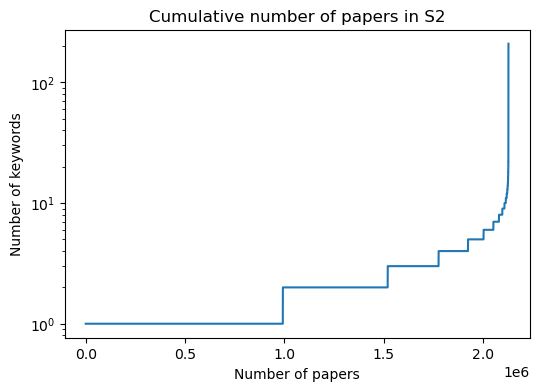

In [6]:
AI_S2 = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/S2_Kwds_AI.parquet")
counts = sorted([el[0] for el in AI_S2.select("Kwd_count").collect()])
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,AI_S2.count(), len(counts)), counts)
plt.xlabel("Number of papers")
plt.ylabel("Number of keywords")
plt.title("Cumulative number of papers in S2")
plt.show()

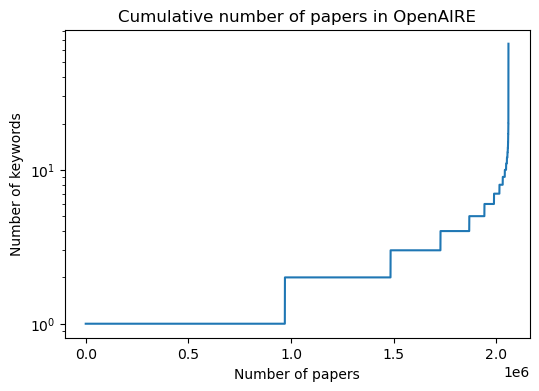

In [7]:
AI_OA = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds_AI.parquet")
counts = sorted([el[0] for el in AI_OA.select("Kwd_count").collect()])
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,AI_OA.count(), len(counts)), counts)
plt.xlabel("Number of papers")
plt.ylabel("Number of keywords")
plt.title("Cumulative number of papers in OpenAIRE")
plt.show()

In [3]:
AI_S2 = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/S2_Kwds_AI.parquet")
print("Number of publications in S2 with 1+ Kwds", AI_S2.count())
AI_S2 = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/S2_Kwds3_AI.parquet")
print("Number of publications in S2 with 3+ Kwds", AI_S2.count())
AI_OA = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds_AI.parquet")
print("Number of publications in OA with 1+ Kwds", AI_OA.count())
AI_OA = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds3_AI.parquet")
print("Number of publications in OA with 3+ Kwds", AI_OA.count())

Number of publications in S2 with 1+ Kwds 2128190


Number of publications in S2 with 3+ Kwds 608155
Number of publications in OA with 1+ Kwds 2058409


Number of publications in OA with 3+ Kwds 574346


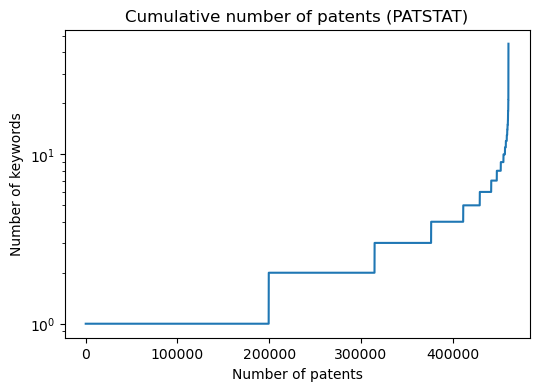

In [6]:
AI_PATSTAT = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds_AI.parquet")
counts = sorted([el[0] for el in AI_PATSTAT.select("Kwd_count").collect()])
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,AI_PATSTAT.count(), len(counts)), counts)
plt.xlabel("Number of patents")
plt.ylabel("Number of keywords")
plt.title("Cumulative number of patents (PATSTAT)")
plt.show()

In [5]:
AI_PATSTAT = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds_AI.parquet")
print("Number of publications in PATSTAT with 1+ Kwds", AI_PATSTAT.count())
AI_PATSTAT = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds3_AI.parquet")
print("Number of publications in PATSTAT with 3+ Kwds", AI_PATSTAT.count())

Number of publications in PATSTAT with 1+ Kwds 460820
Number of publications in PATSTAT with 3+ Kwds 146022


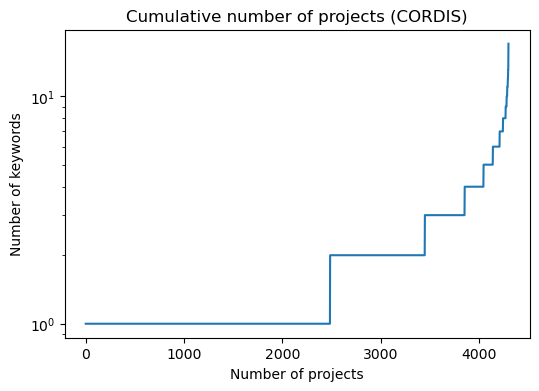

In [7]:
AI_cordis = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/cordis_Kwds_AI.parquet")
counts = sorted([el[0] for el in AI_cordis.select("Kwd_count").collect()])
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,AI_cordis.count(), len(counts)), counts)
plt.xlabel("Number of projects")
plt.ylabel("Number of keywords")
plt.title("Cumulative number of projects (CORDIS)")
plt.show()

In [8]:
AI_cordis = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/cordis_Kwds_AI.parquet")
print("Number of projects in cordis with 1+ Kwds", AI_cordis.count())
AI_cordis = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/cordis_Kwds3_AI.parquet")
print("Number of projects in cordis with 3+ Kwds", AI_cordis.count())

Number of projects in cordis with 1+ Kwds 4301
Number of projects in cordis with 3+ Kwds 852


## 2.2. Topic Modeling

We have trained and we will use a model with 25 topics

|Id|    Size|    Docs Active | ChatGPT Label |   Word description|
| --- | --- | --- | --- | --- |
|0  | 7,81% |   197689  |Artificial Intelligence in Education and Business  | artificial_intelligence, student, machine, chatbot, human, education, social, organization, science, industry, teaching, data, intelligence, business, service|
|1 |  6,11% |   180848  |Machine Learning Algorithms and Data Classification |classifier, SVM, decision_tree, ensemble, machine, random_forest, algorithm, prediction, data, dataset, accuracy, naive_bayes, tree, class, mining|
|2 |  5,72% |   157220  |Expert Systems and Knowledge Management | expert, decision, knowledge, rule, reasoning, support, fuzzy, management, design, ontology, architecture, language, intelligent, theory, domain|
|3 |  5,42% |   124656  |Genetic Algorithms and Optimization | genetic, algorithm, optimization, evolutionary, genetic_algorithm, search, fuzzy, scheduling, optimal, population, parameter, particle_swarm, hybrid, objective, operator|
|4 |  5,31% |   176878  |Deep Neural Networks  |  network, deep, neural, CNN, architecture, layer, deep_learning, ANN, LSTM, training, neuron, train, backpropagation, artificial, classifier|
|5 |  5,05% |   139500  |Generative Adversarial Networks in Deep Learning  |  GAN, label, generative_adversarial, deep, image, data, network, dataset, training, semi_supervised, adversarial, train, autoencoder, representation, generative|
|6 |  4,80% |   124135  |Image Recognition and Computer Vision |  image, recognition, detection, computer_vision, video, deep, object, segmentation, visual, CNN, vision, scene, camera, network, pixel|
|7  | 4,79% |   91382  | Natural Language Processing and Sentiment Analysis | text, sentiment_analysis, word, language, sentiment, natural_language, semantic, sentence, social_media, corpus, classifier, tweet, twitter, document, NLP|
|8  | 4,33% |   116756  |Kernels and Quantum Computing in Machine Learning |  kernel, quantum, algorithm, gaussian_process, optimization, function, gradient_descent, sparse, gradient, convergence, linear, approximation, stochastic_gradient, nonlinear, machine|
|9 |  4,28% |   111083  |Markov Chains and Bayesian Estimation |  markov_chain, HMM, bayesian, markov, state, monte_carlo, distribution, estimation, mcmc, stochastic, parameter, estimate, inference, probability, uncertainty|
|10 | 4,20% |   137807  |Feature Extraction and Pattern Recognition | classifier, SVM, feature, recognition, machine, extraction, selection, kernel, signal, pattern, accuracy, extract, detection, PCA, algorithm|
|11 | 4,02% |   86156  | Medical Prediction and Digital Health  | patient, clinical, disease, diagnosis, prediction, medical, risk, health, treatment, machine, hospital, mortality, healthcare, AUC, cohort|
|12 | 3,86% |   100231 | Fault Diagnosis and Equipment Monitoring  |  fault, sensor, fault_diagnosis, machine, diagnosis, defect, detection, material, monitoring, failure, damage, power, parameter, control, temperature|
|13 | 3,85% |   84226   |Reinforcement Learning and Agent Control  |  reinforcement, agent, multi_agent, robot, control, policy, reinforcement_learning, reward, game, environment, action, controller, state, decision, multiagent|
|14 | 3,50% |   68309   |Speech Recognition and Language Processing | speech, speech_recognition, translation, language, recognition, word, HMM, acoustic, speaker, voice, ASR, dialogue, noise, sentence, text|
|15 | 3,39% |   86364   |Traffic Management and Autonomous Driving |  network, traffic, vehicle, energy, communication, service, deep, reinforcement, sensor, wireless, road, channel, management, node, UAV|
|16 | 3,38% |   84936   |Time Series Prediction and Machine Learning Models | prediction, forecast, SVM, machine, regression, time_series, ANN, data, reservoir, water, neural, network, random_forest, RMSE, root_mean|
|17 | 3,35% |   64750  | Medical Imaging and Deep Learning Diagnosis | image, diagnosis, deep, disease, segmentation, patient, magnetic_resonance, compute_tomography, detection, clinical, classifier, CNN, tumor, imaging, cancer|
|18 | 3,35% |   86605  | Threat Detection and Data Security | detection, attack, security, data, machine, network, intrusion_detection, malware, cloud, IoT, anomaly_detection, privacy, device, deep, traffic|
|19 | 2,73% |   66154  | Agriculture and Spatial Data Analysis |  water, soil, crop, plant, agriculture, spatial, forest, land, urban, satellite, specie, random_forest, environmental, food, risk_factor|
|20 | 2,71% |   85085  | Social Networks and Recommendation Systems | network, graph, bayesian, recommendation, collaborative_filtering, node, item, recommender, representation, structure, prediction, semantic, similarity, bn, preference|
|21 | 2,62% |   57859  | Genetic Prediction and Bioinformatics |  protein, gene, prediction, cell, drug, cancer, molecular, sequence, deoxyribonucleic_acid, disease, chemical, biological, machine, molecule, gene_expression|
|22 | 2,46% |   67737  | Human Activity Recognition and Sensors | brain, activity, recognition, human, electroencephalogram, emotion, cognitive, sensor, motion, signal, gait, movement, detection, gesture, motor|
|23 | 1,92% |   63621  | Clustering and Text Mining | clustering, document, topic, retrieval, text, query, web, data, text_mining, answer, topic_modeling, question_answering, question, semantic, question_answer|
|24 | 1,05% |   29613  | Financial Analysis and Markets | customer, financial, market, company, price, stock, risk, product, stock_market, portfolio, credit, business, stock_price, trading, investment

In [9]:
from IPython.display import IFrame

IFrame('http://www.tsc.uc3m.es/~jarenas/OA_AI_25tpc.html', width=700, height=600)

## 2.3. KPI calculation

### 2.3.1. Scientific Production Trends

#### 2.3.1.1. Publications in AI over time

In [3]:
AI_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds3_AI.parquet"
AI_OA_all = spark.read.parquet(AI_OA_file)

print('Number of publications with AI keywords:', AI_OA_all.count())
AI_OA_all.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords: 574346


-RECORD 0-------------------------------------------------------------------------------------------------------------------------------
 id          | 57a035e5b1ae::cc404b78b9947b9be6bc3db99aee45df                                                                           
 title       | Adaptive courseware model for intelligent e- learning systems                                                            
 description | This paper describes an Adaptive Courseware Tutor – an intelligent tutoring system based on stereotypes, Bayesian net... 
 Kwd_count   | 3                                                                                                                        
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------
 id          | 57a035e5b1ae::e3bee5a5d3300f77a464b1169f851f4b                                                                           
 title       | Agent and Multi-Agent Syst

In [4]:
organization = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/organization").cache()
print('Number of organization available:', organization.count())
organization.printSchema()
organization.show(n=4, truncate=120, vertical=True)

Number of organization available: 314059
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)

-RECORD 0---------------------------------------------------------------------------
 id             | anr_________::1c325fed2fc40eeeeeffbfbc4f4e5f4d                    
 name           | Karlsruhe Institute of Technology - Allemagne                     
 legalshortname | null                                                              
 country        | UNKNOWN                                                           
-RECORD 1---------------------------------------------------------------------------
 id             | anr_________::bb8d415ee418e98e058e936192ec53e8                    
 name           | Physiologie des Adaptations Nutritionnelles                       
 legalshortname | null                                                              
 country        | UNKNOWN        

In [5]:
unique_values_df = organization.select("country").distinct()
unique_values_list = [row["country"] for row in unique_values_df.collect()]
print(len(unique_values_list),unique_values_list)

235 ['LT', 'DZ', 'MM', 'CI', 'TC', 'FI', 'AZ', 'SC', 'UA', 'RO', 'ZM', 'SL', 'NL', 'LA', 'SB', 'MN', 'BW', 'BS', 'PL', 'AM', 'PS', 'RE', 'MK', 'MX', 'PF', 'GL', 'EE', 'VG', 'SM', 'CN', 'AT', 'RU', 'NA', 'IQ', 'SJ', 'CG', 'AD', 'HR', 'SV', 'LI', 'CZ', 'NP', 'VA', 'PT', 'SO', 'PG', 'KY', 'GH', 'CV', 'HK', 'BN', 'LR', 'TW', 'BD', 'PY', 'LB', 'CL', 'TO', 'ID', 'LY', 'FK', 'AU', 'PK', 'SA', 'CA', 'MW', 'BM', 'UZ', 'NE', 'GB', 'YE', 'MT', 'BR', 'KZ', 'NC', 'BY', 'HN', 'GT', 'MD', 'DE', 'GN', 'AW', 'ES', 'IR', 'EC', 'MO', 'BH', 'IL', 'ME', 'TR', 'VE', 'MR', 'ZA', 'CR', 'AI', 'GU', 'KR', 'TZ', 'US', 'RS', 'AQ', 'MS', 'AL', 'MY', 'IN', 'JM', 'GM', 'LC', 'UNKNOWN', 'AE', 'MQ', 'CM', 'RW', 'TG', 'FR', 'GF', 'CH', 'MG', 'TN', 'GQ', 'NU', 'WF', 'TL', 'GR', 'PA', 'TD', 'GI', 'SD', 'AG', 'DJ', 'MC', 'JO', 'BA', 'ET', 'SG', 'KP', 'BF', 'IT', 'CU', 'GW', 'FO', 'MV', 'SE', 'BG', 'PH', 'FJ', 'WS', 'GE', 'SK', 'FM', 'MH', 'CW', 'PE', 'MU', 'LV', 'LS', 'MZ', 'GD', 'DM', 'XK', 'QA', 'DO', 'BZ', 'TH', 'EG', 

In [6]:
EU_countries = {
    'AT' : 'Austria',
    'BE' : 'Belgium',
    'BG' : 'Bulgaria',
    'CY' : 'Cyprus',
    'CZ' : 'Czech Republic',
    'DK' : 'Denmark',
    'EE' : 'Estonia',
    'FI' : 'Finland',
    'FR' : 'France',
    'DE' : 'Germany',
    'GR' : 'Greece',
    'HU' : 'Hungary',
    'IE' : 'Ireland',
    'IT' : 'Italy',
    'LV' : 'Latvia',
    'LT' : 'Lithuania',
    'LU' : 'Luxembourg',
    'MT' : 'Malta',
    'NL' : 'Netherlands',
    'PL' : 'Poland',
    'PT' : 'Portugal',
    'RO' : 'Romania',
    'SK' : 'Slovakia',
    'SI' : 'Slovenia',
    'ES' : 'Spain',
    'SE' : 'Sweden',
    'EU' : 'European Union'
}

EU_countries_list = [el for el in EU_countries.keys()]

In [7]:
EU_organizations = organization.filter(F.col("country").isin(EU_countries_list)).withColumnRenamed("id", "organization")
print('Number of EU organizations available:', EU_organizations.count())
EU_organizations.printSchema()
EU_organizations.show(n=4, truncate=120, vertical=True)

Number of EU organizations available: 85282
root
 |-- organization: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)

-RECORD 0---------------------------------------------------------------------------
 organization   | corda_______::456f6887dd0fa8ad4a4e6919ea3c62ce                    
 name           | DARFU DEL-ALFOLDI REGIONALIS FEJLESZTESI UGYNOKSEG NONPROFIT KFT. 
 legalshortname | DARFU                                                             
 country        | HU                                                                
-RECORD 1---------------------------------------------------------------------------
 organization   | openorgs____::0fdd6fd8d2273c1be274b8d3c285bdea                    
 name           | ECOFOR SRL                                                        
 legalshortname | ECOFOR                                                            
 country        | IT

In [8]:
# We load the list of result_affiliation
result_affiliation = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_affiliation").cache()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 110241706
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)

-RECORD 0------------------------------------------------------
 id           | arXiv_______::0d0195a68f0a5247ff3edc4c0c97da5a 
 organization | openorgs____::f19bd4f95b81943353a480436ef88fd0 
-RECORD 1------------------------------------------------------
 id           | arXiv_______::0e1493b9e93429b73e01e75c5e76f159 
 organization | openorgs____::f1c2611f05338200488d25e838c518d5 
-RECORD 2------------------------------------------------------
 id           | arXiv_______::111398dc0e1a4d4c366b9a02964ee6a9 
 organization | pending_org_::63d0c85afe462ef8dc71bd818ec294a2 
-RECORD 3------------------------------------------------------
 id           | arXiv_______::153aabd37713a7ecb814a60c4ee34912 
 organization | pending_org_::e4e3f394d6d6fda50c450d4dbefd2fb1 
only showing top 4 rows



In [9]:
# And keep only the entries that correspond to EU located organizations
result_affiliation = result_affiliation.join(EU_organizations, on = "organization", how="inner")
print('Number of result_affiliation available (EU affiliations only):', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available (EU affiliations only): 35097551
root
 |-- organization: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0--------------------------------------------------------
 organization   | corda_______::1bc4c6b25345591a19a75920c01af72f 
 id             | doi_dedup___::905fa5a391eb7ec8dac1a92836a212af 
 name           | MEDITOX S.R.O                                  
 legalshortname | MEDITOX                                        
 country        | CZ                                             
-RECORD 1--------------------------------------------------------
 organization   | corda_______::1ee757152ce484f69ea3d53f093fd6cb 
 id             | dedup_wf_001::742e206d36c6501115b28cb63b04fb49 
 name           | Neopost Technologies B.V.                      
 legalshortname | Neopost Technologies                           
 country        | NL                                             
-RECORD 2--------------------------------------------------------
 organization   | corda_____he::3294be1fdd23778e98fc3f29a8a32f9c 
 id             | doi_dedup___::17535c9d5b9580d543bb477ecae550b2 
 name     

In [10]:
# We select now the publications with at least one author with EU affiliation
AI_OA_EU = AI_OA_all.join(result_affiliation, on="id", how="inner").select(["id", "country"]).groupBy("id").agg(F.collect_list("country"))
print('Number of publications with AI keywords and EU affiliation:', AI_OA_EU.count())
AI_OA_EU.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords and EU affiliation: 90540


-RECORD 0---------------------------------------------------------------
 id                    | arXiv_______::2bc2268b52c45369914c4e781314cea5 
 collect_list(country) | [FI]                                           
-RECORD 1---------------------------------------------------------------
 id                    | arXiv_dedup_::8b8b570058296671eb78399aeef663c7 
 collect_list(country) | [FR, FR]                                       
only showing top 2 rows



In [11]:
# Lastly we need to retrieve the publication dates
result_relevantdate = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_relevantdate").cache()
print('Number of result_relevantdate available:', result_relevantdate.count())
result_relevantdate.printSchema()
result_relevantdate.show(n=4, truncate=120, vertical=True)

Number of result_relevantdate available: 322980801
root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- subject: string (nullable = true)

-RECORD 0-------------------------------------------------
 id      | od_______217::0f30bf15292786141deb16512baa0e35 
 type    | issued                                         
 subject | 1985-01-01                                     
-RECORD 1-------------------------------------------------
 id      | od_______217::817776a673860922dd96032e012e341c 
 type    | issued                                         
 subject | 2017-01-01                                     
-RECORD 2-------------------------------------------------
 id      | od_______217::993044844cdc1532ce98b2823482fecf 
 type    | issued                                         
 subject | 2015-04-13                                     
-RECORD 3-------------------------------------------------
 id      | od_______217::bc36e79cfcc744418f1e41e191f5e6fa 
 type   

In [12]:
AI_OA_EU_aux = AI_OA_EU.join(result_relevantdate, on="id", how="inner").withColumn("year", F.substring(F.col("subject"), 1, 4).cast("integer")).drop("subject").drop("type")
print('Number of publications with AI keywords and EU affiliation:', AI_OA_EU_aux.count())
AI_OA_EU_aux.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords and EU affiliation: 233261


-RECORD 0---------------------------------------------------------------
 id                    | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 collect_list(country) | [FR, FR]                                       
 year                  | 2020                                           
-RECORD 1---------------------------------------------------------------
 id                    | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 collect_list(country) | [FR, FR]                                       
 year                  | 2021                                           
only showing top 2 rows



In [13]:
# We now sort in ascending order of year, to keep the most recent date after dropDuplicates
AI_OA_EU = AI_OA_EU_aux.orderBy(AI_OA_EU_aux["year"].asc()).dropDuplicates(["id"])

print('Number of publications with AI keywords and EU affiliation, including only those for which a date is available:', AI_OA_EU.count())
AI_OA_EU.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords and EU affiliation, including only those for which a date is available: 71563


-RECORD 0-----------------------------------------------------------------
 id                    | arXiv_dedup_::1a7d5495bb85bf573d712ca61a21a237   
 collect_list(country) | [FR, FR, FR]                                     
 year                  | 2021                                             
-RECORD 1-----------------------------------------------------------------
 id                    | arXiv_dedup_::2b75b913968d1c98f4d3cbebd73c5d9b   
 collect_list(country) | [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR] 
 year                  | 2022                                             
only showing top 2 rows



In [47]:
all_years = AI_OA_EU.select("year").rdd.flatMap(lambda x: x).collect()
print(all_years[0:10])

[2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011]


In [80]:
print("Number of publications that appeared after 1960 and with valid date", len([el for el in all_years if el>1989 and el <2023]))

Number of publications that appeared after 1960 and with valid date 70724


In [81]:
all_years_plot = [el for el in all_years if el>1989 and el <2023]

In [82]:
from collections import Counter
year_freq = Counter(all_years_plot)
year = list(year_freq.keys())
freq = list(year_freq.values())
year_freq = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

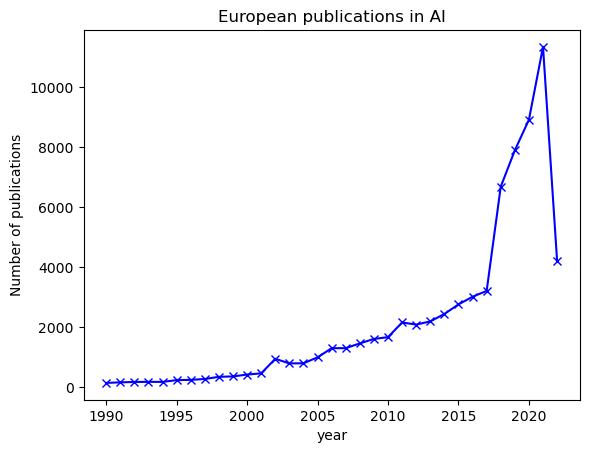

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([el[0] for el in year_freq], [el[1] for el in year_freq], 'b-x')

plt.title('European publications in AI')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.show()

Description/Source: The graph shows the evolution in the number of publications in the AI domain, in the EU (at least one author is affiliated to an EU organization). Data Source: OpenAIRE Graph

In [ ]:
import pickle

with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_1.pickle", "wb") as fout:
    pickle.dump(year_freq, fout)

#### 2.3.1.2. Share of publications in AI topics over time

In [92]:
path2model = "/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models/TMmodels/OA_Kwds3_AI_25tpc/"

with open(path2model + "corpus.txt") as fin:
    corpus_LDA = [el.split()[0].strip() for el in fin.readlines()]

In [94]:
import scipy.sparse as sparse
thetas = sparse.load_npz(path2model + "TMmodel/thetas.npz")

In [148]:
import numpy as np

years = [el[0] for el in year_freq]
topics_over_time = []

for yr in years:
    print(yr)
    publis_yr = AI_OA_EU.filter(AI_OA_EU["year"] == yr).select("id").rdd.flatMap(lambda x: x).collect()
    publis_yr = set(publis_yr)
    pos = [idx for idx,val in enumerate(corpus_LDA) if val in publis_yr]
    topics_over_time.append(np.sum(thetas[pos,:], axis=0).tolist()[0])

topics_over_time = np.array(topics_over_time)

1990


1991


1992


1993


1994


1995


1996


1997


1998


1999


2000


2001


2002


2003


2004


2005


2006


2007


2008


2009


2010


2011


2012


2013


2014


2015


2016


2017


2018


2019


2020


2021


2022


In [145]:
labels = ["Artificial Intelligence in Education and Business",
"Machine Learning Algorithms and Data Classification",
"Expert Systems and Knowledge Management",
"Genetic Algorithms and Optimization",
"Deep Neural Networks",
"Generative Adversarial Networks in Deep Learning",
"Image Recognition and Computer Vision",
"Natural Language Processing and Sentiment Analysis",
"Kernels and Quantum Computing in Machine Learning",
"Markov Chains and Bayesian Estimation",
"Feature Extraction and Pattern Recognition",
"Medical Prediction and Digital Health",
"Fault Diagnosis and Equipment Monitoring",
"Reinforcement Learning and Agent Control",
"Speech Recognition and Language Processing",
"Traffic Management and Autonomous Driving",
"Time Series Prediction and Machine Learning Models",
"Medical Imaging and Deep Learning Diagnosis",
"Threat Detection and Data Security",
"Agriculture and Spatial Data Analysis",
"Social Networks and Recommendation Systems",
"Genetic Prediction and Bioinformatics",
"Human Activity Recognition and Sensors",
"Clustering and Text Mining",
"Financial Analysis and Markets"]

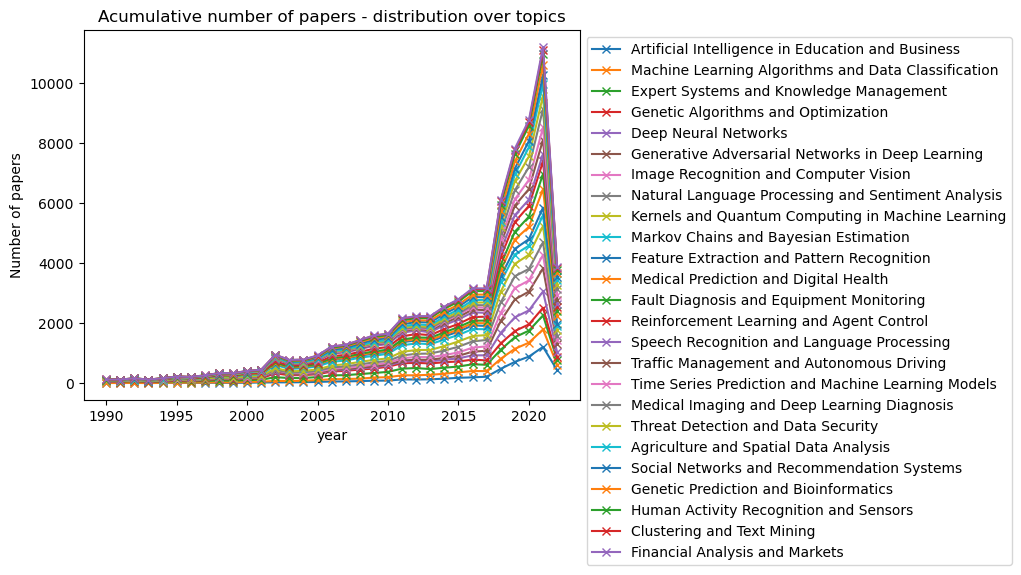

In [149]:
import seaborn as sns

cumulative = np.cumsum(topics_over_time, axis=1)

plt.plot(years, cumulative, 'x-')
# Configuración de etiquetas de ejes
plt.xlabel('year')
plt.ylabel('Number of papers')
plt.title('Acumulative number of papers - distribution over topics')
plt.legend(labels, bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

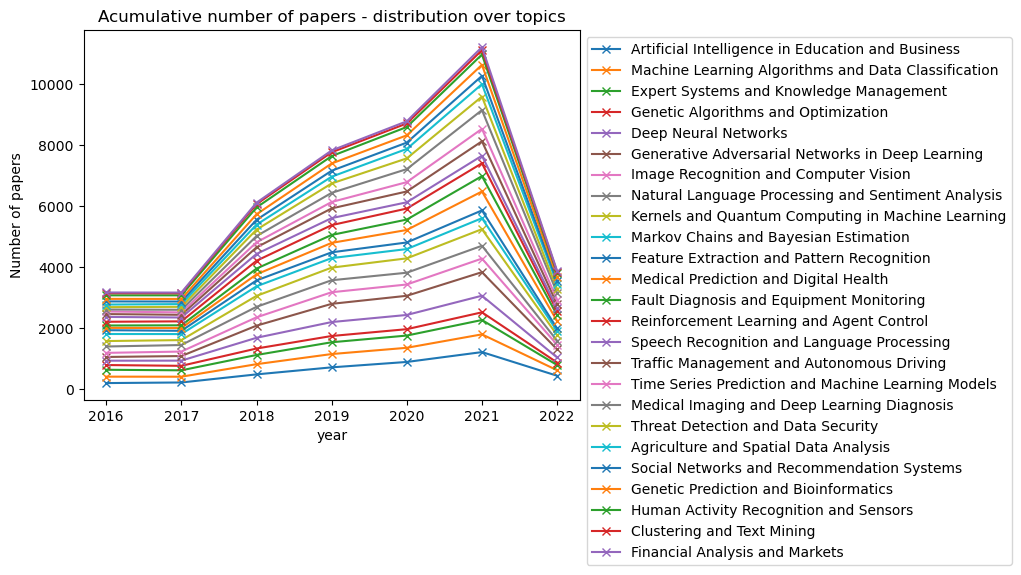

In [150]:
import seaborn as sns

cumulative = np.cumsum(topics_over_time, axis=1)

plt.plot(years[26:], cumulative[26:,], 'x-')
# Configuración de etiquetas de ejes
plt.xlabel('year')
plt.ylabel('Number of papers')
plt.title('Acumulative number of papers - distribution over topics')
plt.legend(labels, bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

In [151]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_2.pickle", "wb") as fout:
    pickle.dump(cumulative, fout)

In [152]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_2_legend.pickle", "wb") as fout:
    pickle.dump(labels, fout)

#### 2.3.1.3. Open Access publications in AI over time

In [158]:
results = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result").cache()
results = results.filter(results["bestaccessrights"] == "Open Access")

AI_OA_EU_open = AI_OA_EU.join(results, on="id", how="inner").drop("dateofcollection").drop("language").drop("type").drop("embargoenddate").drop("dateofacceptance").drop("publisher")
print('Number of Open Access publications with AI keywords and EU affiliation', AI_OA_EU_open.count())
AI_OA_EU_open.show(n=2, truncate=120, vertical=True)

23/09/11 11:27:55 WARN CacheManager: Asked to cache already cached data.


Number of Open Access publications with AI keywords and EU affiliation 42744


-RECORD 0---------------------------------------------------------------
 id                    | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 collect_list(country) | [FR, FR]                                       
 year                  | 2020                                           
 journal               | null                                           
 bestaccessrights      | Open Access                                    
-RECORD 1---------------------------------------------------------------
 id                    | dedup_wf_001::13d83e54b054a21a5986b24cf1c7155a 
 collect_list(country) | [DE]                                           
 year                  | 2006                                           
 journal               | null                                           
 bestaccessrights      | Open Access                                    
only showing top 2 rows



In [159]:
all_years = AI_OA_EU_open.select("year").rdd.flatMap(lambda x: x).collect()
print(all_years[0:10])

[2002, 2021, 2020, 2014, 2014, 2020, 2019, 2022, 2019, 2020]


In [160]:
print("Number of open publications that appeared after 1960 and with valid date", len([el for el in all_years if el>1989 and el <2023]))

Number of open publications that appeared after 1960 and with valid date 42408


In [161]:
all_years_plot = [el for el in all_years if el>1989 and el <2023]

In [162]:
from collections import Counter
year_freq = Counter(all_years_plot)
year = list(year_freq.keys())
freq = list(year_freq.values())
year_freq_open = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

In [164]:
AI_OA_EU_open_journals = AI_OA_EU_open.filter(AI_OA_EU_open["journal"].isNotNull())
print('Number of Open Access publications with AI keywords and EU affiliation (journals only)', AI_OA_EU_open_journals.count())
AI_OA_EU_open_journals.show(n=2, truncate=120, vertical=True)

Number of Open Access publications with AI keywords and EU affiliation (journals only) 17754


-RECORD 0------------------------------------------------------------------
 id                    | doi_________::05d146d8cda8521d9d9d598e8d34f951    
 collect_list(country) | [RO]                                              
 year                  | 2021                                              
 journal               | Procedia Computer Science                         
 bestaccessrights      | Open Access                                       
-RECORD 1------------------------------------------------------------------
 id                    | doi_________::0774f44b3eb5e5155bd7914dae306ade    
 collect_list(country) | [DE]                                              
 year                  | 2020                                              
 journal               | Journal of Computational and Graphical Statistics 
 bestaccessrights      | Open Access                                       
only showing top 2 rows



In [167]:
all_years = AI_OA_EU_open_journals.select("year").rdd.flatMap(lambda x: x).collect()
print(all_years[0:10])

[2014, 2014, 2020, 2019, 2022, 2019, 2020, 2019, 2020, 2019]


In [168]:
print("Number of open publications that appeared after 1960 and with valid date (journals only)", len([el for el in all_years if el>1989 and el <2023]))

Number of open publications that appeared after 1960 and with valid date (journals only) 17625


In [177]:
all_years_plot = [el for el in all_years if el>1989 and el <2023]

In [178]:
year_freq = Counter(all_years_plot)
year = list(year_freq.keys())
freq = list(year_freq.values())
year_freq_open_journals = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

In [179]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_1.pickle", "rb") as fin:
    year_freq = pickle.load(fin)

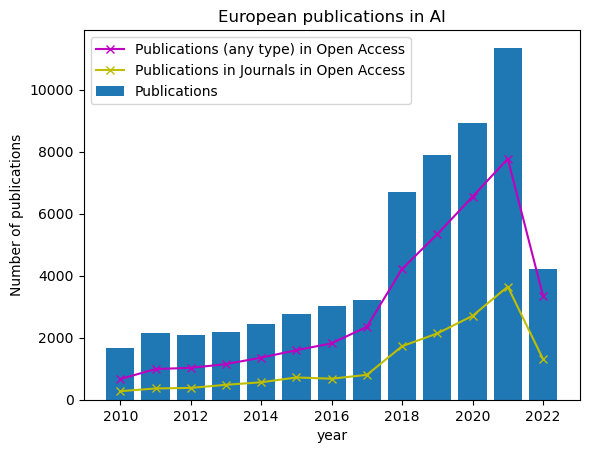

In [184]:
plt.bar([el[0] for el in year_freq][20:], [el[1] for el in year_freq][20:])
plt.plot([el[0] for el in year_freq_open][20:], [el[1] for el in year_freq_open][20:],'m-x')
plt.plot([el[0] for el in year_freq_open_journals][20:], [el[1] for el in year_freq_open_journals][20:],'y-x')

plt.title('European publications in AI')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.legend(["Publications (any type) in Open Access", "Publications in Journals in Open Access", "Publications"])

plt.show()

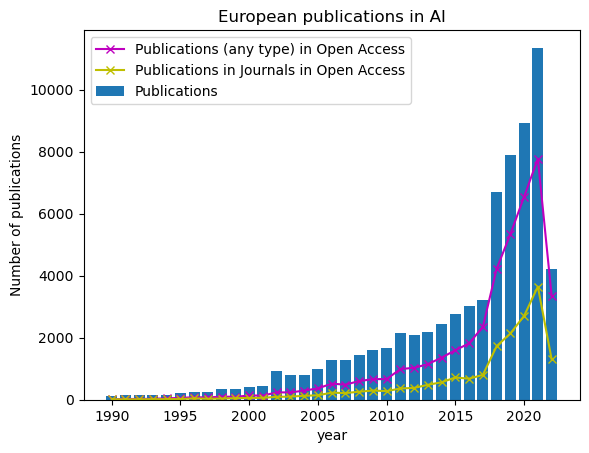

In [185]:
plt.bar([el[0] for el in year_freq], [el[1] for el in year_freq])
plt.plot([el[0] for el in year_freq_open], [el[1] for el in year_freq_open],'m-x')
plt.plot([el[0] for el in year_freq_open_journals], [el[1] for el in year_freq_open_journals],'y-x')

plt.title('European publications in AI')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.legend(["Publications (any type) in Open Access", "Publications in Journals in Open Access", "Publications"])

plt.show()

In [187]:
AI_EU_over_time = {"all": year_freq, "open": year_freq_open, "open_journal": year_freq_open_journals}

with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_3.pickle", "wb") as fout:
    pickle.dump(AI_EU_over_time, fout)

### 2.3.2. Scientific Production Origins

#### 2.3.2.1. Publications by Country

In [199]:
organization = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/organization").withColumnRenamed("id","organization").cache()
organization = organization.filter(organization["country"] != "UNKNOWN")
organization = organization.filter(F.col("country").isNotNull())
organization = organization.select(["organization", "country"])
print('Number of organization available:', organization.count())
organization.printSchema()
organization.show(n=4, truncate=120, vertical=True)

Number of organization available: 221452
root
 |-- organization: string (nullable = true)
 |-- country: string (nullable = true)

-RECORD 0------------------------------------------------------
 organization | corda_______::456f6887dd0fa8ad4a4e6919ea3c62ce 
 country      | HU                                             
-RECORD 1------------------------------------------------------
 organization | openorgs____::0fdd6fd8d2273c1be274b8d3c285bdea 
 country      | IT                                             
-RECORD 2------------------------------------------------------
 organization | openorgs____::149d96b172d2fe45d21ea5636339eb01 
 country      | GB                                             
-RECORD 3------------------------------------------------------
 organization | openorgs____::151e43d1c5c13da381a6d17447b5d45b 
 country      | CN                                             
only showing top 4 rows



23/09/11 13:01:15 WARN CacheManager: Asked to cache already cached data.


In [200]:
# We load the list of result_affiliation
result_affiliation = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_affiliation").cache()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

23/09/11 13:01:23 WARN CacheManager: Asked to cache already cached data.


Number of result_affiliation available: 110241706
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)

-RECORD 0------------------------------------------------------
 id           | arXiv_______::0d0195a68f0a5247ff3edc4c0c97da5a 
 organization | openorgs____::f19bd4f95b81943353a480436ef88fd0 
-RECORD 1------------------------------------------------------
 id           | arXiv_______::0e1493b9e93429b73e01e75c5e76f159 
 organization | openorgs____::f1c2611f05338200488d25e838c518d5 
-RECORD 2------------------------------------------------------
 id           | arXiv_______::111398dc0e1a4d4c366b9a02964ee6a9 
 organization | pending_org_::63d0c85afe462ef8dc71bd818ec294a2 
-RECORD 3------------------------------------------------------
 id           | arXiv_______::153aabd37713a7ecb814a60c4ee34912 
 organization | pending_org_::e4e3f394d6d6fda50c450d4dbefd2fb1 
only showing top 4 rows



In [201]:
# Add country to the previous
result_affiliation = result_affiliation.join(organization, on="organization", how="inner")
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 108386546
root
 |-- organization: string (nullable = true)
 |-- id: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0------------------------------------------------------
 organization | corda_______::1bc4c6b25345591a19a75920c01af72f 
 id           | doi_dedup___::905fa5a391eb7ec8dac1a92836a212af 
 country      | CZ                                             
-RECORD 1------------------------------------------------------
 organization | corda_______::1ee757152ce484f69ea3d53f093fd6cb 
 id           | dedup_wf_001::742e206d36c6501115b28cb63b04fb49 
 country      | NL                                             
-RECORD 2------------------------------------------------------
 organization | corda_____he::3294be1fdd23778e98fc3f29a8a32f9c 
 id           | doi_dedup___::17535c9d5b9580d543bb477ecae550b2 
 country      | DE                                             
-RECORD 3------------------------------------------------------
 organization | corda_____he::3294be1fdd23778e98fc3f29a8a32f9c 
 id           | doi_dedup___::bd8efade2c8f6a706a3f810d96d113d3 
 country      | DE                      

In [202]:
print('Number of publications with AI keywords and EU affiliation, including only those for which a date is available:', AI_OA_EU.count())
AI_OA_EU.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords and EU affiliation, including only those for which a date is available: 71563


-RECORD 0-----------------------------------------------------------------
 id                    | arXiv_dedup_::1a7d5495bb85bf573d712ca61a21a237   
 collect_list(country) | [FR, FR, FR]                                     
 year                  | 2021                                             
-RECORD 1-----------------------------------------------------------------
 id                    | arXiv_dedup_::2b75b913968d1c98f4d3cbebd73c5d9b   
 collect_list(country) | [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR] 
 year                  | 2022                                             
only showing top 2 rows



In [203]:
# We create a dataframe with organization, id, country only
AI_OA_EU_country = AI_OA_EU.select(["id", "year"])
AI_OA_EU_country = AI_OA_EU_country.join(result_affiliation, on="id", how="inner")
print('Number of publications / country assignments available:', AI_OA_EU_country.count())
AI_OA_EU_country.show(n=2, truncate=120, vertical=True)

Number of publications / country assignments available: 167381


-RECORD 0------------------------------------------------------
 id           | doi_________::a077b6a1b8b67a4544b206c5b7851ee9 
 year         | 1998                                           
 organization | openorgs____::32d39b07d757bf27d8bea5731550637e 
 country      | PT                                             
-RECORD 1------------------------------------------------------
 id           | doi_________::764895589494f345006a047a092f0479 
 year         | 2018                                           
 organization | openorgs____::a84ddd5e002000d5c3caee5bcd9e2cfe 
 country      | SE                                             
only showing top 2 rows



In [204]:
AI_OA_EU_country_aux = AI_OA_EU_country.select(["id","country"]).groupBy("id").agg(F.collect_list("country"))
print('Number of publications / country assignments available:', AI_OA_EU_country_aux.count())
AI_OA_EU_country_aux.show(n=2, truncate=120, vertical=True)

Number of publications / country assignments available: 71563


-RECORD 0---------------------------------------------------------------
 id                    | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 collect_list(country) | [FR, FR]                                       
-RECORD 1---------------------------------------------------------------
 id                    | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 collect_list(country) | [US, FR, FR]                                   
only showing top 2 rows



In [205]:
all_countries = AI_OA_EU_country_aux.select("collect_list(country)").rdd.flatMap(lambda x: x).collect()

In [206]:
flat_list = [el for sublist in all_countries for el in sublist]

In [209]:
country_freq = Counter(flat_list)
country = list(country_freq.keys())
freq = list(country_freq.values())
country_freq = {el1: el2 for el1, el2 in zip(country,freq)}

In [212]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_2_1.pickle", "wb") as fout:
    pickle.dump(country_freq, fout)

#### 2.3.2.2. Publications by organization (top 100)

In [213]:
organization = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/organization").withColumnRenamed("id","organization").cache()
print('Number of organization available:', organization.count())
organization.printSchema()
organization.show(n=4, truncate=120, vertical=True)

23/09/11 15:33:08 WARN CacheManager: Asked to cache already cached data.


Number of organization available: 314059
root
 |-- organization: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0---------------------------------------------------------------------------
 organization   | anr_________::1c325fed2fc40eeeeeffbfbc4f4e5f4d                    
 name           | Karlsruhe Institute of Technology - Allemagne                     
 legalshortname | null                                                              
 country        | UNKNOWN                                                           
-RECORD 1---------------------------------------------------------------------------
 organization   | anr_________::bb8d415ee418e98e058e936192ec53e8                    
 name           | Physiologie des Adaptations Nutritionnelles                       
 legalshortname | null                                                              
 country        | UNKNOWN                                                           
-RECORD 2---------------------------------------------------------------------------
 organization   | corda_______::456f6887dd0fa8ad4a4e6919ea3c62ce 

In [214]:
# We load the list of result_affiliation
result_affiliation = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_affiliation").cache()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

23/09/11 15:34:03 WARN CacheManager: Asked to cache already cached data.


Number of result_affiliation available: 110241706
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)

-RECORD 0------------------------------------------------------
 id           | arXiv_______::0d0195a68f0a5247ff3edc4c0c97da5a 
 organization | openorgs____::f19bd4f95b81943353a480436ef88fd0 
-RECORD 1------------------------------------------------------
 id           | arXiv_______::0e1493b9e93429b73e01e75c5e76f159 
 organization | openorgs____::f1c2611f05338200488d25e838c518d5 
-RECORD 2------------------------------------------------------
 id           | arXiv_______::111398dc0e1a4d4c366b9a02964ee6a9 
 organization | pending_org_::63d0c85afe462ef8dc71bd818ec294a2 
-RECORD 3------------------------------------------------------
 id           | arXiv_______::153aabd37713a7ecb814a60c4ee34912 
 organization | pending_org_::e4e3f394d6d6fda50c450d4dbefd2fb1 
only showing top 4 rows



In [215]:
print('Number of publications with AI keywords and EU affiliation, including only those for which a date is available:', AI_OA_EU.count())
AI_OA_EU.show(n=2, truncate=120, vertical=True)

Number of publications with AI keywords and EU affiliation, including only those for which a date is available: 71563


-RECORD 0-----------------------------------------------------------------
 id                    | arXiv_dedup_::1a7d5495bb85bf573d712ca61a21a237   
 collect_list(country) | [FR, FR, FR]                                     
 year                  | 2021                                             
-RECORD 1-----------------------------------------------------------------
 id                    | arXiv_dedup_::2b75b913968d1c98f4d3cbebd73c5d9b   
 collect_list(country) | [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR] 
 year                  | 2022                                             
only showing top 2 rows



In [216]:
# Keep only result_affiliation for the relevant papers
result_affiliation = result_affiliation.join(AI_OA_EU, on="id", how="inner").select(["id", "organization"])
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 180409
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)



-RECORD 0------------------------------------------------------
 id           | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 organization | openorgs____::52fb6d8aa6e9640ab897049c9fab6341 
-RECORD 1------------------------------------------------------
 id           | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 organization | openorgs____::c80a8243a5e5c620d7931c88d93bf17a 
-RECORD 2------------------------------------------------------
 id           | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 organization | openorgs____::c80a8243a5e5c620d7931c88d93bf17a 
-RECORD 3------------------------------------------------------
 id           | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 organization | openorgs____::15f2d0993187da791e8efa1f431d6c6c 
only showing top 4 rows



In [217]:
# Count only each affiliation once (i.e., no se cuenta múltiples veces si hay varios investigadores de la misma organización)
result_affiliation = result_affiliation.dropDuplicates()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 180409
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)



-RECORD 0------------------------------------------------------
 id           | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 organization | openorgs____::52fb6d8aa6e9640ab897049c9fab6341 
-RECORD 1------------------------------------------------------
 id           | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 organization | openorgs____::c80a8243a5e5c620d7931c88d93bf17a 
-RECORD 2------------------------------------------------------
 id           | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 organization | pending_org_::b09d5df759dd8acda060397d5f9d27be 
-RECORD 3------------------------------------------------------
 id           | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 organization | openorgs____::c80a8243a5e5c620d7931c88d93bf17a 
only showing top 4 rows



In [218]:
# Replace organization id by organization name
result_affiliation = result_affiliation.join(organization, on="organization", how="inner")
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 180401
root
 |-- organization: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0-----------------------------------------------------------
 organization   | anr_________::07f0ebde10137bd5c2255ec0b03d9386    
 id             | doi_dedup___::8b7efeff1f825865821113c4e9d99782    
 name           | Université Nantes                                 
 legalshortname | null                                              
 country        | UNKNOWN                                           
-RECORD 1-----------------------------------------------------------
 organization   | anr_________::312430365c19935995e48c7a3a40e71d    
 id             | doi_dedup___::28eb0bb2100eeeb80d6d8cccd72e8f7a    
 name           | Université Bourgogne-Franche-comté                
 legalshortname | null                                              
 country        | UNKNOWN                                           
-RECORD 2-----------------------------------------------------------
 organization   | anr_________::312430365c19935995e48c7a3a40e71d    
 id             | doi_dedup___::2a

In [219]:
all_organizations = result_affiliation.select("name").rdd.flatMap(lambda x: x).collect()

organization_freq = Counter(all_organizations)

top100 = organization_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

Université Paris Diderot: 7269
French Institute for Research in Computer Science and Automation: 2297
KU Leuven: 1382
University of Copenhagen: 1307
Inserm: 1191
University of Amsterdam: 945
French National Centre for Scientific Research: 936
Max Planck Society: 866
Universitat Politècnica de València: 857
University of Cambridge: 772
University of Granada: 749
Karlsruhe Institute of Technology: 748
Carnegie Mellon University: 731
University of Oxford: 710
Fraunhofer Society: 702
Sapienza University of Rome: 698
Imperial College London: 687
Delft University of Technology: 668
National Research Council: 662
RWTH Aachen University: 657
Aalto University: 656
Universidad Politécnica de Madrid: 655
Aalborg University: 622
Ghent University: 619
Polytechnic University of Milan: 615
Alma Mater Studiorum University of Bologna: 612
University Federico II of Naples: 558
University of Padua: 553
University of Edinburgh: 524
Institut Pasteur: 518
Stanford University: 517
University of Marne la Vall

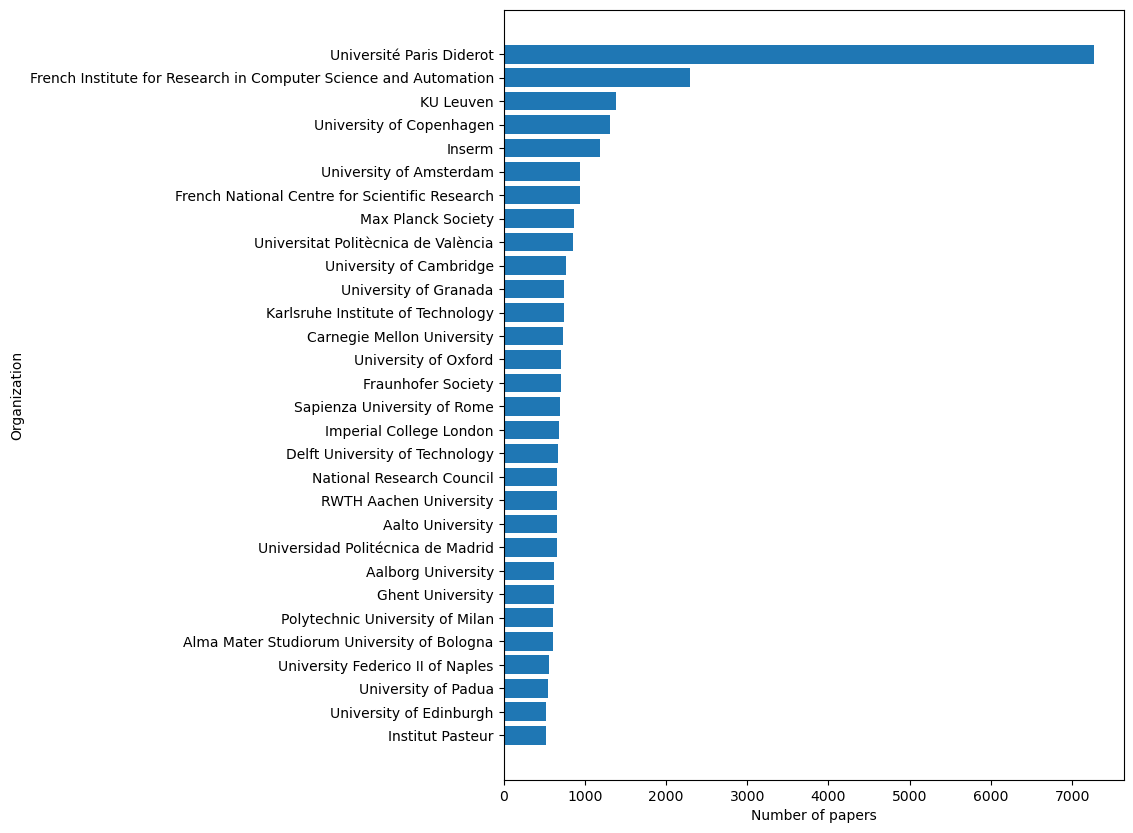

In [222]:
orgs = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(orgs[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Number of papers')
plt.ylabel('Organization')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

In [224]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_2_2.pickle", "wb") as fout:
    pickle.dump(organization_freq, fout)

#### 2.3.2.3. Publications by Funder

In [223]:
result_project = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_project").cache()
print('Number of result_project available:', result_project.count())
result_project.printSchema()
result_project.show(n=4, truncate=120, vertical=True)

Number of result_project available: 5386150
root
 |-- id: string (nullable = true)
 |-- project: string (nullable = true)

-RECORD 0-------------------------------------------------
 id      | 57a035e5b1ae::1008bd45199be35e79f88082cf6f41c2 
 project | irb_hr______::2669e0d43c4213e26d8aa1534c58b30b 
-RECORD 1-------------------------------------------------
 id      | 57a035e5b1ae::a3264873505e971859d36093dc6cf337 
 project | irb_hr______::a3eeae587bcddb80a0f5f3cbb134ea6b 
-RECORD 2-------------------------------------------------
 id      | arXiv_______::05d02f08278e1ad4ac0548780244a481 
 project | corda__h2020::985a86ddffa25cacf60d38af5634c509 
-RECORD 3-------------------------------------------------
 id      | arXiv_______::407dad8c044f988d4592172368424d72 
 project | corda_______::f422e97791e34995d54bf773dfb2007d 
only showing top 4 rows



In [225]:
# Keep only result_project for the relevant papers
result_project = result_project.join(AI_OA_EU, on="id", how="inner").select(["id", "project"])
print('Number of result_project available:', result_project.count())
result_project.printSchema()
result_project.show(n=4, truncate=120, vertical=True)

Number of result_project available: 12570
root
 |-- id: string (nullable = true)
 |-- project: string (nullable = true)



-RECORD 0-------------------------------------------------
 id      | doi_dedup___::0176455a2f9398ce6eab4996fe18d822 
 project | sfi_________::11af76d66c1314db6cb551446c915c2f 
-RECORD 1-------------------------------------------------
 id      | doi_dedup___::0512a38c8ae6b90bb5698632d59974ea 
 project | corda__h2020::9bd5d9709ef7f78f6ec3bf0325b3a2b5 
-RECORD 2-------------------------------------------------
 id      | doi_dedup___::0cb11cc496afce98ad729ee03d4f86fb 
 project | corda__h2020::aaa915a78e6d5905b8e7a88130cade70 
-RECORD 3-------------------------------------------------
 id      | doi_dedup___::0ed166c78b205c5310c4e58b7ef401a5 
 project | corda__h2020::0958dbd706fe8975a769615f0f97617d 
only showing top 4 rows



In [226]:
project_funding = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/project_funding").withColumnRenamed("id","project").cache()
print('Number of project_funding available:', project_funding.count())
project_funding.printSchema()
project_funding.show(n=4, truncate=120, vertical=True)

Number of project_funding available: 3295519
root
 |-- project: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- funding_lvl0: string (nullable = true)
 |-- funding_lvl1: string (nullable = true)
 |-- funding_lvl2: string (nullable = true)

-RECORD 0------------------------------------------------------
 project      | snsf________::b9a1d494f88facd686cc85af93a6f51e 
 funder       | Swiss National Science Foundation              
 funding_lvl0 | Programmes                                     
 funding_lvl1 | ERA-NET                                        
 funding_lvl2 | ERA-E-RARE                                     
-RECORD 1------------------------------------------------------
 project      | nih_________::bdd53acbb1d3f91c0c6d6984164f9190 
 funder       | National Institutes of Health                  
 funding_lvl0 | NATIONAL INSTITUTE ON AGING                    
 funding_lvl1 |                                                
 funding_lvl2 |                     

In [228]:
result_funder = result_project.join(project_funding, on="project", how="inner")

In [229]:
all_funders = result_funder.select("funder").rdd.flatMap(lambda x: x).collect()

funders_freq = Counter(all_funders)

top100 = funders_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

European Commission: 5545
National Science Foundation: 963
National Institutes of Health: 757
French National Research Agency (ANR): 600
Fundação para a Ciência e a Tecnologia, I.P.: 483
Academy of Finland: 460
UK Research and Innovation: 411
Natural Sciences and Engineering Research Council of Canada: 242
Netherlands Organisation for Scientific Research (NWO): 221
Swiss National Science Foundation: 221
Wellcome Trust: 217
Science Foundation Ireland: 190
Austrian Science Fund (FWF): 100
Canadian Institutes of Health Research: 59
Australian Research Council (ARC): 46
CHIST-ERA: 41
National Health and Medical Research Council (NHMRC): 14
Ministry of Education, Science and Technological Development of Republic of Serbia: 14
Social Sciences and Humanities Research Council: 11
Croatian Science Foundation (CSF): 9
Ministry of Science, Education and Sports of the Republic of Croatia (MSES): 2
Tara Expeditions Foundation: 2
Türkiye Bilimsel ve Teknolojik Araştırma Kurumu: 2


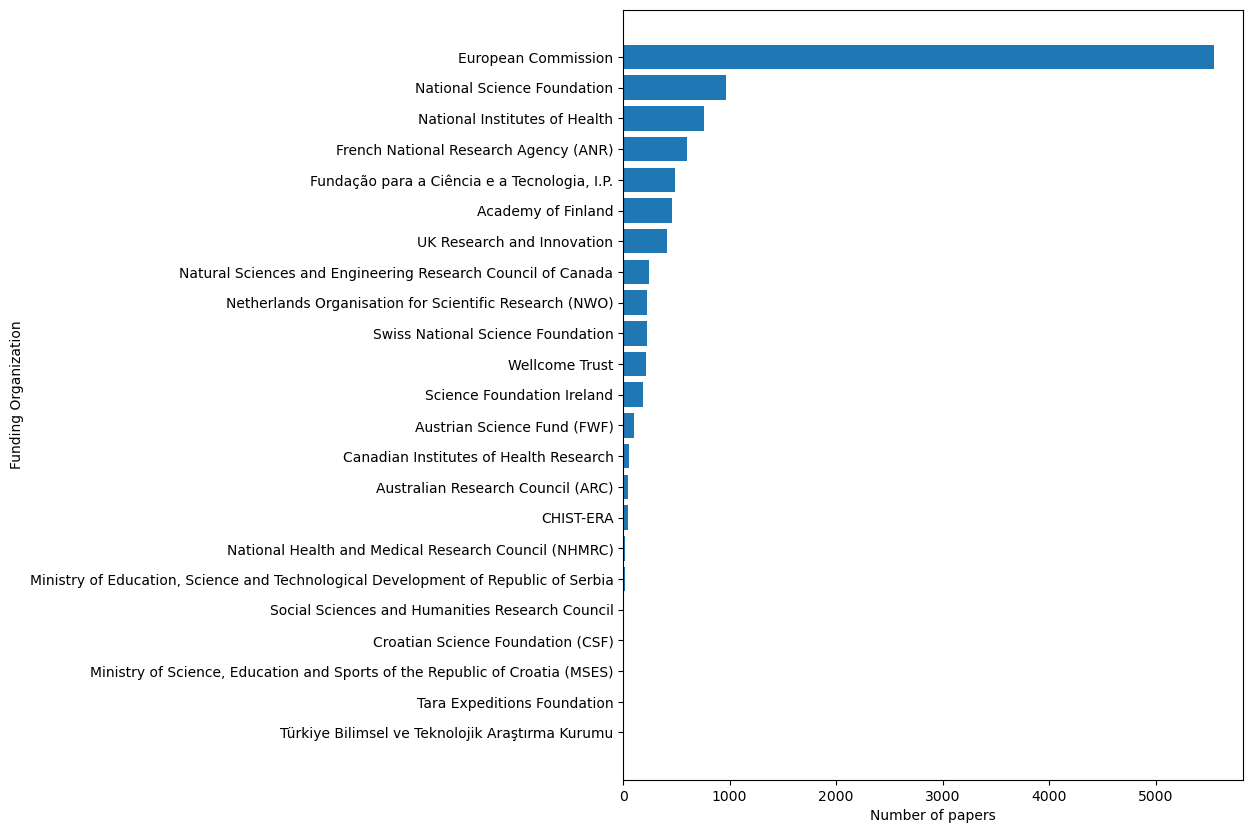

In [230]:
funder = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(funder[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Number of papers')
plt.ylabel('Funding Organization')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

In [231]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_2_3.pickle", "wb") as fout:
    pickle.dump(funders_freq, fout)

### 2.3.3. Scientific Production Characteristics

#### 2.3.3.2. Top 50 Journals

In [232]:
result = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result").cache()
result = result.filter(F.col("journal").isNotNull())
print('Number of results in journals:', result.count())
result.printSchema()
result.show(n=4, truncate=120, vertical=True)

23/09/11 16:37:13 WARN CacheManager: Asked to cache already cached data.


Number of results in journals: 107121594
root
 |-- id: string (nullable = true)
 |-- dateofcollection: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- bestaccessrights: string (nullable = true)
 |-- language: string (nullable = true)
 |-- dateofacceptance: string (nullable = true)
 |-- embargoenddate: string (nullable = true)
 |-- type: string (nullable = true)



-RECORD 0--------------------------------------------------------------------------------------
 id               | 4dc99724cf04::3f50ec12aae287378b096e493848ff1c                             
 dateofcollection | 2020-04-10T08:26:05.612Z                                                   
 publisher        | Facultad de Medicina Humana de la Universidad Nacional Mayor de San Marcos 
 journal          | Anales de la Facultad de Medicina                                          
 bestaccessrights | Open Access                                                                
 language         | Spanish; Castilian                                                         
 dateofacceptance | 1956-06-18                                                                 
 embargoenddate   | null                                                                       
 type             | publication                                                                
-RECORD 1-------------------------------

In [233]:
# Keep only result results in the selected target dataset
result = result.join(AI_OA_EU, on="id", how="inner")

In [234]:
print('Number of results in AI in journals:', result.count())
result.printSchema()
result.show(n=4, truncate=120, vertical=True)

Number of results in AI in journals: 34420
root
 |-- id: string (nullable = true)
 |-- dateofcollection: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- bestaccessrights: string (nullable = true)
 |-- language: string (nullable = true)
 |-- dateofacceptance: string (nullable = true)
 |-- embargoenddate: string (nullable = true)
 |-- type: string (nullable = true)
 |-- collect_list(country): array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)



-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------
 id                    | doi_________::0227325c93da3bdc434f4bbd66a8c144                                                                           
 dateofcollection      | 2023-01-12T23:26:14Z                                                                                                     
 publisher             | IEEE                                                                                                                     
 journal               | Neural Networks for Signal Processing IX: Proceedings of the 1999 IEEE Signal Processing Society Workshop (Cat. No.98... 
 bestaccessrights      | not available                                                                                                            
 language              | Undetermined                                                                                 

In [235]:
all_journals = result.select("journal").rdd.flatMap(lambda x: x).collect()

journals_freq = Counter(all_journals)

top100 = journals_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

IEEE Access: 456
Expert Systems with Applications: 407
Sensors: 302
SSRN Electronic Journal: 299
Neurocomputing: 241
SPIE Proceedings: 237
Procedia Computer Science: 203
IFAC Proceedings Volumes: 193
PLoS ONE: 171
Applied Soft Computing: 148
Scientific Reports: 135
Applied Sciences: 134
Information Sciences: 132
Knowledge-Based Systems: 123
Sensors (Basel, Switzerland): 122
BMC Bioinformatics: 122
PLOS ONE: 120
Pattern Recognition Letters: 120
Remote Sensing: 119
Engineering Applications of Artificial Intelligence: 113
Pattern Recognition: 106
IFAC-PapersOnLine: 93
Speech Communication: 86
European Journal of Operational Research: 80
Computers and Electronics in Agriculture: 80
Bioinformatics: 76
Procedia CIRP: 73
International Journal of Approximate Reasoning: 73
Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. Annual International Conference: 67
IEEE Transactions on Geoscience and Remote Sensing

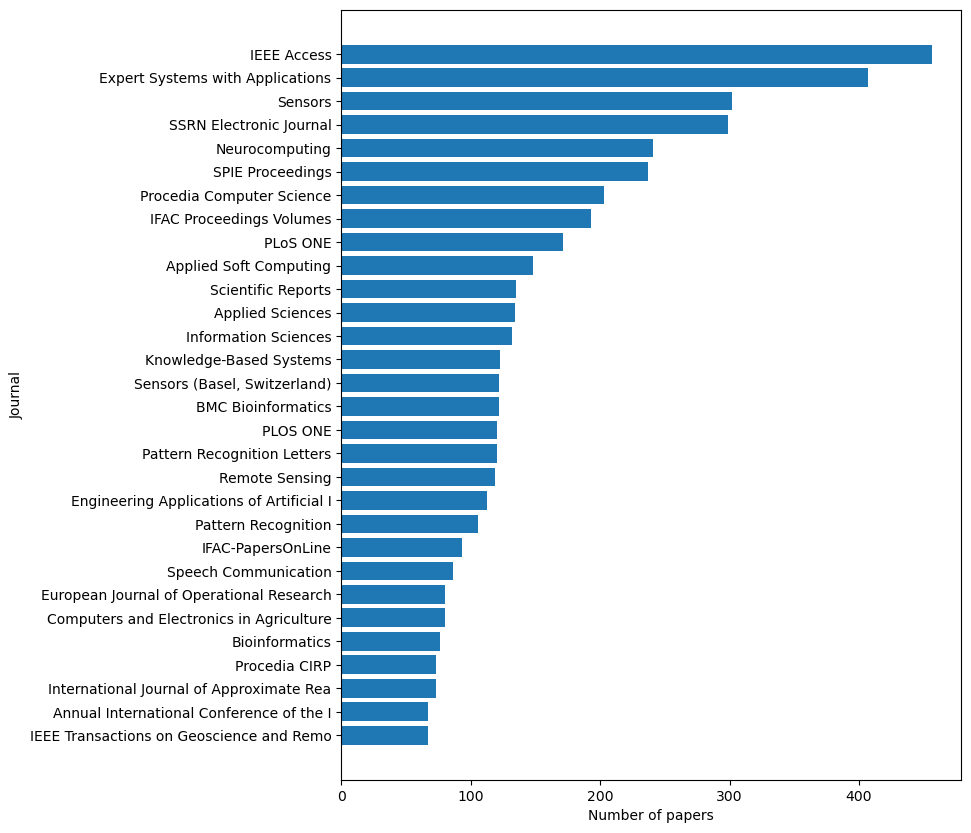

I0911 17:33:43.642354 27296 detector.cpp:152] Detected a new leader: (id='10876')
I0911 17:33:43.642398 27296 group.cpp:700] Trying to get '/mesos/json.info_0000010876' in ZooKeeper
I0911 17:33:43.643240 27289 zookeeper.cpp:262] A new leading master (UPID=master@10.0.12.77:5050) is detected
I0911 17:33:43.643456 27282 sched.cpp:345] New master detected at master@10.0.12.77:5050
I0911 17:33:43.643553 27282 sched.cpp:410] Authenticating with master master@10.0.12.77:5050
I0911 17:33:43.643558 27282 sched.cpp:417] Using default CRAM-MD5 authenticatee
I0911 17:33:43.643611 27297 authenticatee.cpp:121] Creating new client SASL connection
I0911 17:33:47.640398 27291 detector.cpp:152] Detected a new leader: (id='10877')
I0911 17:33:47.640452 27291 group.cpp:700] Trying to get '/mesos/json.info_0000010877' in ZooKeeper
I0911 17:33:47.641196 27291 zookeeper.cpp:262] A new leading master (UPID=master@10.0.12.76:5050) is detected
I0911 17:33:47.641247 27286 sched.cpp:345] New master detected at m

In [238]:
journal = [el[:40] for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(journal[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Number of papers')
plt.ylabel('Journal')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

In [237]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_3_2.pickle", "wb") as fout:
    pickle.dump(funders_freq, fout)

### 2.3.4. Scientific impact trends 

#### 2.3.4.1. Publications cited in patents

In [14]:
result_instance_pid = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_instance_pid").cache()
result_instance_pid = result_instance_pid.filter(result_instance_pid["type"] == "Digital Object Identifier")
print('Number of dois:', result_instance_pid.count())
result_instance_pid.printSchema()
result_instance_pid.show(n=4, truncate=120, vertical=True)

23/09/11 23:17:40 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


Number of dois: 176527468
root
 |-- id: string (nullable = true)
 |-- result: string (nullable = true)
 |-- type: string (nullable = true)
 |-- pid: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------
 id     | doi_________::000866c3a2c8ca86a0ab01264171b6ec::a1d680b6ded9d71c5a7ecb5d92a99715 
 result | doi_________::000866c3a2c8ca86a0ab01264171b6ec                                   
 type   | Digital Object Identifier                                                        
 pid    | 10.17876/plate/dr.2/envelopes/201_48236                                          
-RECORD 1----------------------------------------------------------------------------------
 id     | doi_________::002e16e5443d0bfe5f93fc4662ee8b0c::27eb4c5dfa35c3387e67354125caed3c 
 result | doi_________::002e16e5443d0bfe5f93fc4662ee8b0c                                   
 type   | Digital Object Identifier                                                      

In [15]:
result_instance_pid = result_instance_pid.select(["result", "pid"]).withColumnRenamed("result","id").withColumnRenamed("pid", "doi")
print('Number of dois:', result_instance_pid.count())
result_instance_pid.printSchema()
result_instance_pid.show(n=4, truncate=120, vertical=True)

Number of dois: 176527468
root
 |-- id: string (nullable = true)
 |-- doi: string (nullable = true)

-RECORD 0---------------------------------------------
 id  | doi_________::000866c3a2c8ca86a0ab01264171b6ec 
 doi | 10.17876/plate/dr.2/envelopes/201_48236        
-RECORD 1---------------------------------------------
 id  | doi_________::002e16e5443d0bfe5f93fc4662ee8b0c 
 doi | 10.5281/zenodo.155672                          
-RECORD 2---------------------------------------------
 id  | doi_________::00398641af05623a9bd22b5e904460bc 
 doi | 10.15156/bio/sh223397.07fu                     
-RECORD 3---------------------------------------------
 id  | doi_________::005283cc10a0da74a543bcde56de219d 
 doi | 10.1037/e403272005-002                         
only showing top 4 rows



In [16]:
AI_OA_EU_doi = AI_OA_EU.join(result_instance_pid, on="id", how="inner").select(["id", "doi", "year"])
print('Number of relevant EU publications with dois:', AI_OA_EU_doi.count())
AI_OA_EU_doi.printSchema()
AI_OA_EU_doi.show(n=4, truncate=120, vertical=True)

Number of relevant EU publications with dois: 106136
root
 |-- id: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- year: integer (nullable = true)



-RECORD 0----------------------------------------------
 id   | doi_dedup___::664301b18166ee8f22fd0115d11a73a1 
 doi  | 10.1109/ijcnn.2018.8489241                     
 year | 2018                                           
-RECORD 1----------------------------------------------
 id   | doi_dedup___::664301b18166ee8f22fd0115d11a73a1 
 doi  | 10.1109/ijcnn.2018.8489241                     
 year | 2018                                           
-RECORD 2----------------------------------------------
 id   | doi_________::9eed9c9d03793ef36079362c2145d1dd 
 doi  | 10.1016/j.asoc.2012.03.015                     
 year | 2012                                           
-RECORD 3----------------------------------------------
 id   | doi_dedup___::8ea5117fff026abffa55cbd69cdb28b3 
 doi  | 10.1007/978-3-030-50578-3_25                   
 year | 2020                                           
only showing top 4 rows



In [20]:
npl_citations = spark.read.parquet(path2PATSTAT + "npl_citations.parquet").select("npl_doi").withColumnRenamed("npl_doi", "doi").cache()
npl_citations = npl_citations.filter(F.col("doi").isNotNull())
print('Number of NPL citations with DOI:', npl_citations.count())
npl_citations.printSchema()
npl_citations.show(n=4, truncate=120, vertical=True)

23/09/11 23:42:59 WARN CacheManager: Asked to cache already cached data.


Number of NPL citations with DOI: 1938151
root
 |-- doi: string (nullable = true)

-RECORD 0----------------------------
 doi | 10.1109/CVPRW53098.2021.00012 
-RECORD 1----------------------------
 doi | 10.1021/acs.chemmater.5b02595 
-RECORD 2----------------------------
 doi | 10.1021/acs.chemmater.5b02595 
-RECORD 3----------------------------
 doi | 10.1053/J.GASTRO.2010.06.047  
only showing top 4 rows



In [22]:
AI_OA_EU_doi_patstat = AI_OA_EU_doi.join(npl_citations, on="doi", how="inner").dropDuplicates(["id"])
print('Number of AI publications cited in PATSTAT:', AI_OA_EU_doi_patstat.count())
AI_OA_EU_doi_patstat.printSchema()
AI_OA_EU_doi_patstat.show(n=4, truncate=120, vertical=True)

Number of AI publications cited in PATSTAT: 547
root
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- year: integer (nullable = true)



-RECORD 0----------------------------------------------
 doi  | 10.1002/hbm.23730                              
 id   | doi_________::033100b451107ed57e056e9cfe5322ae 
 year | 2017                                           
-RECORD 1----------------------------------------------
 doi  | 10.1007/978-3-319-24574-4_28                   
 id   | doi_________::03514f62b5c6ee7753c7e11b2b047f8a 
 year | 2015                                           
-RECORD 2----------------------------------------------
 doi  | 10.1007/978-3-540-30228-5_18                   
 id   | doi_________::037650ef57cb0926ec42a70509387ef0 
 year | 2004                                           
-RECORD 3----------------------------------------------
 doi  | 10.1186/1471-2105-6-104                        
 id   | doi_________::04b71bff68a7e74dd108e98514ecddea 
 year | 2005                                           
only showing top 4 rows



In [23]:
all_years_npl = AI_OA_EU_doi_patstat.select("year").rdd.flatMap(lambda x: x).collect()

NameError: name 'Counter' is not defined

In [25]:
from collections import Counter

npl_freq = Counter(all_years_npl)

year = list(npl_freq.keys())
freq = list(npl_freq.values())

npl_freq = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

In [28]:
import pickle

with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_1_1.pickle", "rb") as fin:
    year_freq = pickle.load(fin)

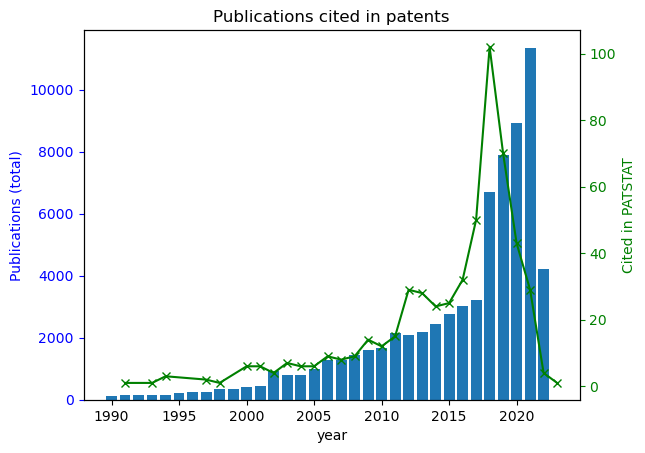

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar([el[0] for el in year_freq], [el[1] for el in year_freq], label="Publications (total)")
ax1.set_xlabel('year')
ax1.set_ylabel('Publications (total)', color='b')
ax1.tick_params('y', colors='b')

ax2.plot([el[0] for el in npl_freq], [el[1] for el in npl_freq], 'g-x', label="Publications cited in patents")
ax2.set_ylabel('Cited in PATSTAT', color='g')
ax2.tick_params('y', colors='g')

plt.title("Publications cited in patents")
plt.show()

In [ ]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_4_1.pickle", "wb") as fout:
    pickle.dump(npl_freq, fout)

#### 2.3.4.2. Average citation per publication over time

#### 2.3.4.3. Total citations over time

In [35]:
result_citations = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_citations").cache()
print('Number of citations:', result_citations.count())
result_citations.printSchema()
result_citations.show(n=4, truncate=120, vertical=True)

Number of citations: 1277513949
root
 |-- id: string (nullable = true)
 |-- target: string (nullable = true)

-RECORD 0------------------------------------------------
 id     | doi_________::0000bb1da39af46c1c64dc11ac1a5b17 
 target | doi_________::8bf41e24e45eb75adbe5fc8a55a6f566 
-RECORD 1------------------------------------------------
 id     | doi_________::0000ed1830f939df304f965aeb01ff44 
 target | doi_________::32f38d2794ebcef3704ece65f6eebc2f 
-RECORD 2------------------------------------------------
 id     | doi_________::000228af67c92f29dac75d5be146cb65 
 target | doi_dedup___::44a2694d6305dd47b160ae80c930dc8f 
-RECORD 3------------------------------------------------
 id     | doi_________::000228af67c92f29dac75d5be146cb65 
 target | doi_dedup___::2b824ba8e30474a57cbf6a59430ee159 
only showing top 4 rows



In [36]:
# We keep a dataframe containing only the cited papers, and make the inner join with the AI papers

result_citations = result_citations.select(["target"]).withColumnRenamed("target", "id")
citations_AI_OA_EU = result_citations.join(AI_OA_EU, on="id", how="inner")

print('Number of citations to AI papers:', citations_AI_OA_EU.count())
citations_AI_OA_EU.printSchema()
citations_AI_OA_EU.show(n=4, truncate=120, vertical=True)

23/09/12 00:42:23 ERROR TaskSchedulerImpl: Lost executor 2 on node33.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 00:42:23 WARN TaskSetManager: Lost task 36.0 in stage 379.0 (TID 12261) (node33.cluster.tsc.uc3m.es executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 00:42:23 WARN TaskSetManager: Lost task 9.0 in stage 379.0 (TID 12234) (node33.cluster.tsc.uc3m.es executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 00:42:23 WARN TaskSetManager: Lost task 18.0 in stage 379.0 (TID 12243) (node33.clus

Number of citations to AI papers: 1175717
root
 |-- id: string (nullable = true)
 |-- collect_list(country): array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)



-RECORD 0---------------------------------------------------------------
 id                    | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 collect_list(country) | [BE]                                           
 year                  | 2003                                           
-RECORD 1---------------------------------------------------------------
 id                    | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 collect_list(country) | [BE]                                           
 year                  | 2003                                           
-RECORD 2---------------------------------------------------------------
 id                    | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 collect_list(country) | [BE]                                           
 year                  | 2003                                           
-RECORD 3---------------------------------------------------------------
 id                    | doi_________::0227325c93da

In [38]:
citas_year = citations_AI_OA_EU.select("year").rdd.flatMap(lambda x: x).collect()

citas_year = Counter(citas_year)

year = list(citas_year.keys())
citas = list(citas_year.values())

citas_year = sorted([(el1, el2) for el1, el2 in zip(year,citas)], key=lambda x: x[0])

In [40]:
citas_year

[(1963, 7),
 (1969, 21),
 (1970, 9),
 (1971, 4),
 (1972, 4),
 (1973, 10),
 (1974, 10),
 (1976, 2),
 (1977, 15),
 (1979, 8),
 (1980, 111),
 (1981, 80),
 (1982, 52),
 (1983, 64),
 (1984, 31),
 (1985, 233),
 (1986, 95),
 (1987, 267),
 (1988, 472),
 (1989, 498),
 (1990, 654),
 (1991, 781),
 (1992, 1017),
 (1993, 1127),
 (1994, 913),
 (1995, 1273),
 (1996, 1441),
 (1997, 1632),
 (1998, 2200),
 (1999, 2356),
 (2000, 3030),
 (2001, 3462),
 (2002, 5878),
 (2003, 6277),
 (2004, 6023),
 (2005, 8213),
 (2006, 11919),
 (2007, 12333),
 (2008, 14359),
 (2009, 17159),
 (2010, 17321),
 (2011, 28261),
 (2012, 26264),
 (2013, 29822),
 (2014, 33854),
 (2015, 40929),
 (2016, 47081),
 (2017, 47106),
 (2018, 102838),
 (2019, 123401),
 (2020, 127137),
 (2021, 332312),
 (2022, 108886),
 (2023, 6187),
 (2117, 37),
 (2120, 65),
 (2850, 99),
 (9999, 77)]

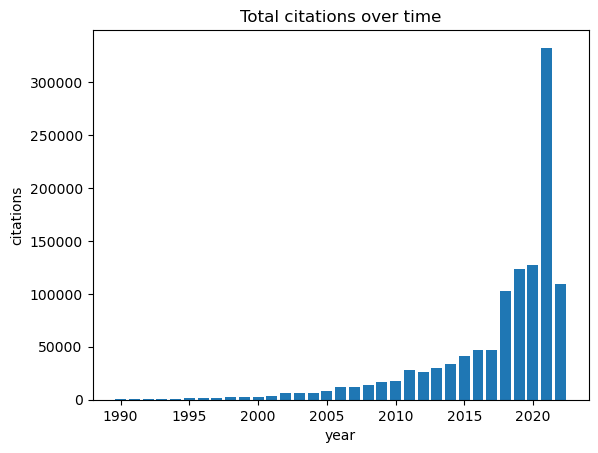

In [42]:
# Beware there are some elements out of range

plt.bar([el[0] for el in citas_year][20:-5], [el[1] for el in citas_year][20:-5])

plt.title('Total citations over time')
plt.xlabel('year')
plt.ylabel('citations')

plt.show()

In [43]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_4_3.pickle", "wb") as fout:
    pickle.dump(citas_year, fout)

In [45]:
citas_year = {el[0]:el[1] for el in citas_year}

In [48]:
year_freq = {el[0]:el[1] for el in year_freq}

In [50]:
years = [el for el in range(1990,2023)]
av_cit = [citas_year[el]/year_freq[el] for el in years]

In [52]:
av_citas_year = [(el[0], el[1]) for el in zip(years, av_cit)]

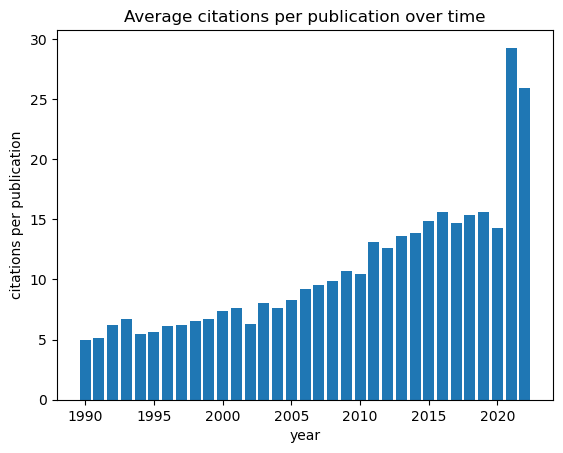

In [53]:
plt.bar([el[0] for el in av_citas_year], [el[1] for el in av_citas_year])

plt.title('Average citations per publication over time')
plt.xlabel('year')
plt.ylabel('citations per publication')

plt.show()

In [54]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_4_2.pickle", "wb") as fout:
    pickle.dump(av_citas_year, fout)

### 2.3.5. Scientific impact origin

#### 2.3.5.1. Average number of citations per publication by country

In [55]:
citations_AI_OA_EU = citations_AI_OA_EU.select("id").cache()
print("Total number of citations", citations_AI_OA_EU.count())

23/09/12 01:25:03 ERROR TaskSchedulerImpl: Lost executor 15 on node94.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 01:25:03 WARN TaskSetManager: Lost task 7.0 in stage 460.0 (TID 17252) (node94.cluster.tsc.uc3m.es executor 15): ExecutorLostFailure (executor 15 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 01:25:03 WARN TaskSetManager: Lost task 5.0 in stage 460.0 (TID 17242) (node94.cluster.tsc.uc3m.es executor 15): ExecutorLostFailure (executor 15 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 01:25:03 WARN TaskSetManager: Lost task 17.0 in stage 460.0 (TID 17262) (node94.

Total number of citations 1175717


In [56]:
organization = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/organization").withColumnRenamed("id","organization").cache()
organization = organization.filter(organization["country"] != "UNKNOWN")
organization = organization.filter(F.col("country").isNotNull())
organization = organization.select(["organization", "country"])
print('Number of organization available:', organization.count())
organization.printSchema()
organization.show(n=4, truncate=120, vertical=True)

Number of organization available: 221452
root
 |-- organization: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0------------------------------------------------------
 organization | corda_______::456f6887dd0fa8ad4a4e6919ea3c62ce 
 country      | HU                                             
-RECORD 1------------------------------------------------------
 organization | openorgs____::0fdd6fd8d2273c1be274b8d3c285bdea 
 country      | IT                                             
-RECORD 2------------------------------------------------------
 organization | openorgs____::149d96b172d2fe45d21ea5636339eb01 
 country      | GB                                             
-RECORD 3------------------------------------------------------
 organization | openorgs____::151e43d1c5c13da381a6d17447b5d45b 
 country      | CN                                             
only showing top 4 rows



In [57]:
# We load the list of result_affiliation
result_affiliation = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_affiliation").cache()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

23/09/12 08:17:48 WARN CacheManager: Asked to cache already cached data.
23/09/12 08:18:03 ERROR TaskSchedulerImpl: Lost executor 10 on node76.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 08:18:03 WARN TaskSetManager: Lost task 44.0 in stage 476.0 (TID 17509) (node76.cluster.tsc.uc3m.es executor 10): ExecutorLostFailure (executor 10 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/09/12 08:18:03 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_707_765 !
23/09/12 08:18:03 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_926_54 !
23/09/12 08:18:03 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_926_133 !
23/09/12 08:18:03 WARN BlockManagerMasterEndpoint: No more replicas av

Number of result_affiliation available: 110241706
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)



-RECORD 0------------------------------------------------------
 id           | arXiv_______::0d0195a68f0a5247ff3edc4c0c97da5a 
 organization | openorgs____::f19bd4f95b81943353a480436ef88fd0 
-RECORD 1------------------------------------------------------
 id           | arXiv_______::0e1493b9e93429b73e01e75c5e76f159 
 organization | openorgs____::f1c2611f05338200488d25e838c518d5 
-RECORD 2------------------------------------------------------
 id           | arXiv_______::111398dc0e1a4d4c366b9a02964ee6a9 
 organization | pending_org_::63d0c85afe462ef8dc71bd818ec294a2 
-RECORD 3------------------------------------------------------
 id           | arXiv_______::153aabd37713a7ecb814a60c4ee34912 
 organization | pending_org_::e4e3f394d6d6fda50c450d4dbefd2fb1 
only showing top 4 rows



In [58]:
# Add country to the previous
result_affiliation = result_affiliation.join(organization, on="organization", how="inner")
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 108386546
root
 |-- organization: string (nullable = true)
 |-- id: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0------------------------------------------------------
 organization | corda_______::1bc4c6b25345591a19a75920c01af72f 
 id           | doi_dedup___::905fa5a391eb7ec8dac1a92836a212af 
 country      | CZ                                             
-RECORD 1------------------------------------------------------
 organization | corda_______::1ee757152ce484f69ea3d53f093fd6cb 
 id           | dedup_wf_001::742e206d36c6501115b28cb63b04fb49 
 country      | NL                                             
-RECORD 2------------------------------------------------------
 organization | corda_____he::3294be1fdd23778e98fc3f29a8a32f9c 
 id           | doi_dedup___::bd8efade2c8f6a706a3f810d96d113d3 
 country      | DE                                             
-RECORD 3------------------------------------------------------
 organization | corda_____he::3294be1fdd23778e98fc3f29a8a32f9c 
 id           | doi_dedup___::17535c9d5b9580d543bb477ecae550b2 
 country      | DE                      

In [61]:
# We create a dataframe with for citations including the country only
citations_AI_OA_EU_country = citations_AI_OA_EU.join(result_affiliation, on="id", how="inner")
print('Number of publications / country assignments available:', citations_AI_OA_EU_country.count())
citations_AI_OA_EU_country.show(n=2, truncate=120, vertical=True)

Number of publications / country assignments available: 3192136


-RECORD 0------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
 country      | BE                                             
-RECORD 1------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
 country      | BE                                             
only showing top 2 rows



In [62]:
all_countries = citations_AI_OA_EU_country.select("country").rdd.flatMap(lambda x: x).collect()

In [64]:
citations_country_freq = Counter(all_countries)
country = list(citations_country_freq.keys())
freq = list(citations_country_freq.values())
citations_country_freq = {el1: el2 for el1, el2 in zip(country,freq)}

In [66]:
citations_country_freq

{'BE': 76946,
 'PT': 55420,
 'DE': 357865,
 'PL': 54220,
 'ES': 233899,
 'LT': 8125,
 'FR': 381424,
 'AU': 44564,
 'DK': 79651,
 'CA': 47289,
 'IT': 299592,
 'SI': 14770,
 'CN': 110969,
 'RO': 17172,
 'IN': 28553,
 'KR': 16224,
 'BR': 21239,
 'NL': 123455,
 'US': 375123,
 'SE': 71185,
 'CH': 49046,
 'MX': 6653,
 'GR': 54535,
 'BG': 4426,
 'HU': 19980,
 'FI': 88330,
 'MY': 6556,
 'PK': 7322,
 'GB': 187524,
 'AT': 43870,
 'JP': 20968,
 'BD': 2596,
 'UA': 2243,
 'SK': 6623,
 'LU': 6425,
 'LV': 3441,
 'IR': 23215,
 'CZ': 23727,
 'NO': 17094,
 'IE': 35103,
 'RU': 9097,
 'VN': 13274,
 'BY': 576,
 'ZA': 4477,
 'UZ': 28,
 'TR': 7686,
 'RW': 983,
 'QA': 3573,
 'AE': 3426,
 'SA': 8638,
 'BF': 71,
 'MA': 1748,
 'SG': 15664,
 'HR': 2265,
 'CO': 6103,
 'EG': 6723,
 'NZ': 4685,
 'CY': 6531,
 'TN': 2804,
 'IL': 8498,
 'TW': 7247,
 'TH': 2035,
 'SY': 93,
 'KW': 477,
 'EE': 5374,
 'CL': 3838,
 'MT': 1295,
 'PH': 793,
 'EC': 1832,
 'LB': 1617,
 'DZ': 2189,
 'CM': 180,
 'KE': 843,
 'ID': 1409,
 'CU': 662

In [65]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_5_1.pickle", "wb") as fout:
    pickle.dump(citations_country_freq, fout)

#### 2.3.5.2. Average number of citations per publication by organization (top 100)

In [67]:
organization = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/organization").withColumnRenamed("id","organization").cache()
print('Number of organization available:', organization.count())
organization.printSchema()
organization.show(n=4, truncate=120, vertical=True)

23/09/12 08:45:54 WARN CacheManager: Asked to cache already cached data.


Number of organization available: 314059
root
 |-- organization: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)

-RECORD 0---------------------------------------------------------------------------
 organization   | anr_________::1c325fed2fc40eeeeeffbfbc4f4e5f4d                    
 name           | Karlsruhe Institute of Technology - Allemagne                     
 legalshortname | null                                                              
 country        | UNKNOWN                                                           
-RECORD 1---------------------------------------------------------------------------
 organization   | anr_________::bb8d415ee418e98e058e936192ec53e8                    
 name           | Physiologie des Adaptations Nutritionnelles                       
 legalshortname | null                                                              
 country        | UNKNO

In [68]:
# We load the list of result_affiliation
result_affiliation = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_affiliation").cache()
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

23/09/12 08:46:09 WARN CacheManager: Asked to cache already cached data.


Number of result_affiliation available: 110241706
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)

-RECORD 0------------------------------------------------------
 id           | arXiv_______::0d0195a68f0a5247ff3edc4c0c97da5a 
 organization | openorgs____::f19bd4f95b81943353a480436ef88fd0 
-RECORD 1------------------------------------------------------
 id           | arXiv_______::0e1493b9e93429b73e01e75c5e76f159 
 organization | openorgs____::f1c2611f05338200488d25e838c518d5 
-RECORD 2------------------------------------------------------
 id           | arXiv_______::111398dc0e1a4d4c366b9a02964ee6a9 
 organization | pending_org_::63d0c85afe462ef8dc71bd818ec294a2 
-RECORD 3------------------------------------------------------
 id           | arXiv_______::153aabd37713a7ecb814a60c4ee34912 
 organization | pending_org_::e4e3f394d6d6fda50c450d4dbefd2fb1 
only showing top 4 rows



In [69]:
# Enrich citations with affiliation
result_affiliation = result_affiliation.join(citations_AI_OA_EU, on="id", how="inner").select(["id", "organization"])
print('Number of result_affiliation for citations:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation for citations: 3320882
root
 |-- id: string (nullable = true)
 |-- organization: string (nullable = true)



-RECORD 0------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
-RECORD 1------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
-RECORD 2------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
-RECORD 3------------------------------------------------------
 id           | doi_________::0227325c93da3bdc434f4bbd66a8c144 
 organization | openorgs____::ccc0a066b56d2cfaf90c2ae369df16f5 
only showing top 4 rows



In [70]:
# Replace organization id by organization name
result_affiliation = result_affiliation.join(organization, on="organization", how="inner")
print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 3320686
root
 |-- organization: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- legalshortname: string (nullable = true)
 |-- country: string (nullable = true)



-RECORD 0--------------------------------------------------------
 organization   | anr_________::07f0ebde10137bd5c2255ec0b03d9386 
 id             | doi_dedup___::8b7efeff1f825865821113c4e9d99782 
 name           | Université Nantes                              
 legalshortname | null                                           
 country        | UNKNOWN                                        
-RECORD 1--------------------------------------------------------
 organization   | anr_________::07f0ebde10137bd5c2255ec0b03d9386 
 id             | doi_dedup___::8b7efeff1f825865821113c4e9d99782 
 name           | Université Nantes                              
 legalshortname | null                                           
 country        | UNKNOWN                                        
-RECORD 2--------------------------------------------------------
 organization   | anr_________::07f0ebde10137bd5c2255ec0b03d9386 
 id             | doi_dedup___::8b7efeff1f825865821113c4e9d99782 
 name     

In [71]:
all_organizations = result_affiliation.select("name").rdd.flatMap(lambda x: x).collect()

organization_cit_freq = Counter(all_organizations)

In [72]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_5_2.pickle", "wb") as fout:
    pickle.dump(organization_cit_freq, fout)

In [73]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_2_2.pickle", "rb") as fin:
    organization_freq = pickle.load(fin)

In [84]:
av_cit_counter = Counter()

min_requested_publis = 100

for key in organization_cit_freq:
    if organization_freq[key]>=min_requested_publis:
        av_cit_counter[key] = organization_cit_freq[key] / organization_freq[key]


In [85]:
top100 = av_cit_counter.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

Forschungszentrum Jülich: 35.849673202614376
Wageningen University & Research: 35.36875
Mayo Clinic: 33.58878504672897
Institut de Recherche pour le Développement: 33.462857142857146
Helmholtz Association of German Research Centres: 32.78921568627451
National University of Singapore: 32.46927374301676
Charité - University Medicine Berlin: 32.44604316546763
University of Konstanz: 31.641025641025642
University of Southern Denmark: 31.32608695652174
Medical University of Vienna: 31.06015037593985
University of Michigan–Flint: 30.984126984126984
University of Geneva: 30.67479674796748
Catholic University of the Sacred Heart: 30.423076923076923
University of Vienna: 30.306976744186045
University of Münster: 29.755725190839694
Florida Southern College: 29.4
University of Santiago de Compostela: 28.900709219858157
Luleå University of Technology: 28.397905759162303
Humboldt-Universität zu Berlin: 28.228448275862068
Hebei University: 27.719298245614034
Shanghai Jiao Tong University: 27.6160714

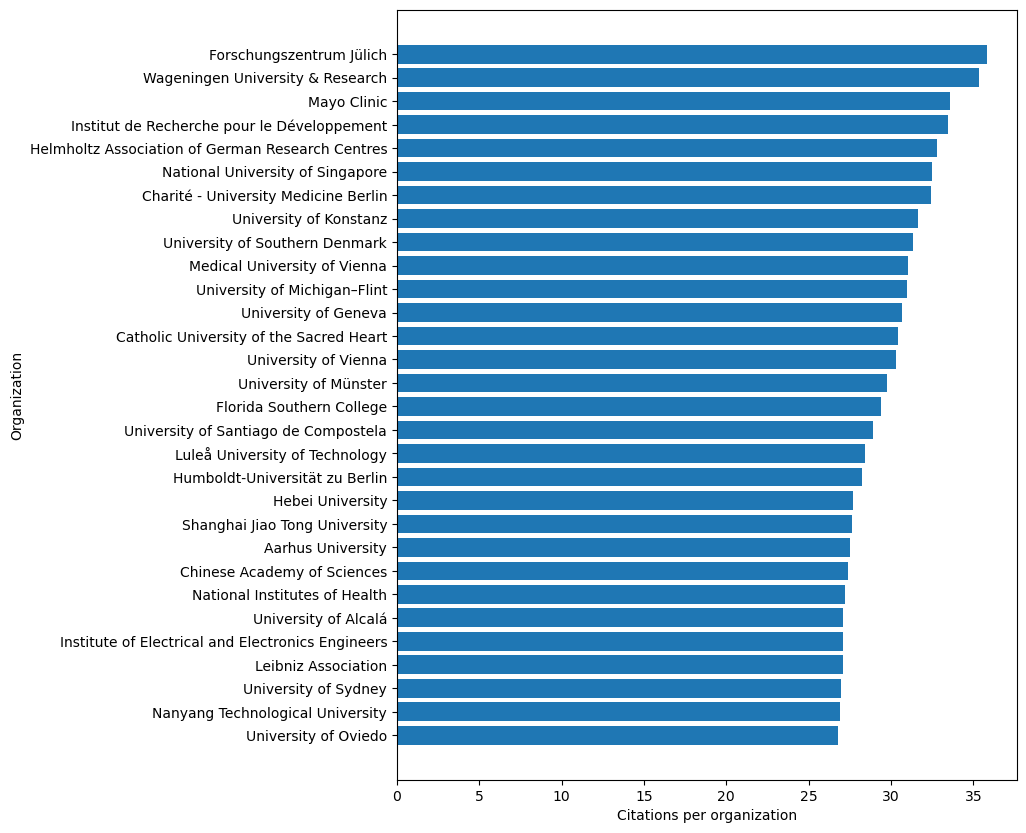

In [86]:
orgs = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(orgs[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Citations per organization')
plt.ylabel('Organization')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

#### 2.3.5.3. Average number of citations per publication by funder

In [87]:
result_project = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/result_project").cache()
print('Number of result_project available:', result_project.count())
result_project.printSchema()
result_project.show(n=4, truncate=120, vertical=True)

Number of result_project available: 5386150
root
 |-- id: string (nullable = true)
 |-- project: string (nullable = true)

-RECORD 0-------------------------------------------------
 id      | 57a035e5b1ae::1008bd45199be35e79f88082cf6f41c2 
 project | irb_hr______::2669e0d43c4213e26d8aa1534c58b30b 
-RECORD 1-------------------------------------------------
 id      | 57a035e5b1ae::a3264873505e971859d36093dc6cf337 
 project | irb_hr______::a3eeae587bcddb80a0f5f3cbb134ea6b 
-RECORD 2-------------------------------------------------
 id      | arXiv_______::05d02f08278e1ad4ac0548780244a481 
 project | corda__h2020::985a86ddffa25cacf60d38af5634c509 
-RECORD 3-------------------------------------------------
 id      | arXiv_______::407dad8c044f988d4592172368424d72 
 project | corda_______::f422e97791e34995d54bf773dfb2007d 
only showing top 4 rows



In [89]:
# Keep only result_project for the citations
result_project = result_project.join(citations_AI_OA_EU, on="id", how="inner").select(["id", "project"])
print('Number of result_project available:', result_project.count())
result_project.printSchema()
result_project.show(n=4, truncate=120, vertical=True)

Number of result_project available: 319155
root
 |-- id: string (nullable = true)
 |-- project: string (nullable = true)



-RECORD 0-------------------------------------------------
 id      | doi_dedup___::0512a38c8ae6b90bb5698632d59974ea 
 project | corda__h2020::9bd5d9709ef7f78f6ec3bf0325b3a2b5 
-RECORD 1-------------------------------------------------
 id      | doi_dedup___::0512a38c8ae6b90bb5698632d59974ea 
 project | corda__h2020::9bd5d9709ef7f78f6ec3bf0325b3a2b5 
-RECORD 2-------------------------------------------------
 id      | doi_dedup___::0512a38c8ae6b90bb5698632d59974ea 
 project | corda__h2020::9bd5d9709ef7f78f6ec3bf0325b3a2b5 
-RECORD 3-------------------------------------------------
 id      | doi_dedup___::0512a38c8ae6b90bb5698632d59974ea 
 project | corda__h2020::9bd5d9709ef7f78f6ec3bf0325b3a2b5 
only showing top 4 rows



In [90]:
project_funding = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/project_funding").withColumnRenamed("id","project").cache()
print('Number of project_funding available:', project_funding.count())
project_funding.printSchema()
project_funding.show(n=4, truncate=120, vertical=True)

Number of project_funding available: 3295519
root
 |-- project: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- funding_lvl0: string (nullable = true)
 |-- funding_lvl1: string (nullable = true)
 |-- funding_lvl2: string (nullable = true)

-RECORD 0------------------------------------------------------
 project      | snsf________::b9a1d494f88facd686cc85af93a6f51e 
 funder       | Swiss National Science Foundation              
 funding_lvl0 | Programmes                                     
 funding_lvl1 | ERA-NET                                        
 funding_lvl2 | ERA-E-RARE                                     
-RECORD 1------------------------------------------------------
 project      | nih_________::bdd53acbb1d3f91c0c6d6984164f9190 
 funder       | National Institutes of Health                  
 funding_lvl0 | NATIONAL INSTITUTE ON AGING                    
 funding_lvl1 |                                                
 funding_lvl2 |                     

In [91]:
result_funder = result_project.join(project_funding, on="project", how="inner")

In [92]:
all_funders = result_funder.select("funder").rdd.flatMap(lambda x: x).collect()

funders_cit_freq = Counter(all_funders)

In [93]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_5_3.pickle", "wb") as fout:
    pickle.dump(funders_cit_freq, fout)

In [95]:
with open("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/Science_2_3.pickle", "rb") as fin:
    funders_freq = pickle.load(fin)

In [99]:
av_cit_counter = Counter()

min_requested_publis = 100

for key in funders_cit_freq:
    if funders_freq[key]>=min_requested_publis:
        av_cit_counter[key] = funders_cit_freq[key] / funder_freq[key]


In [100]:
top100 = av_cit_counter.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

Swiss National Science Foundation: 30.70135746606335
National Institutes of Health: 28.673712021136062
Academy of Finland: 28.191304347826087
Natural Sciences and Engineering Research Council of Canada: 24.34297520661157
Austrian Science Fund (FWF): 23.91
European Commission: 23.61064021641118
Wellcome Trust: 21.16589861751152
Fundação para a Ciência e a Tecnologia, I.P.: 20.77846790890269
UK Research and Innovation: 20.00729927007299
National Science Foundation: 18.786085150571132
French National Research Agency (ANR): 18.541666666666668
Science Foundation Ireland: 16.46315789473684
Netherlands Organisation for Scientific Research (NWO): 14.714932126696832


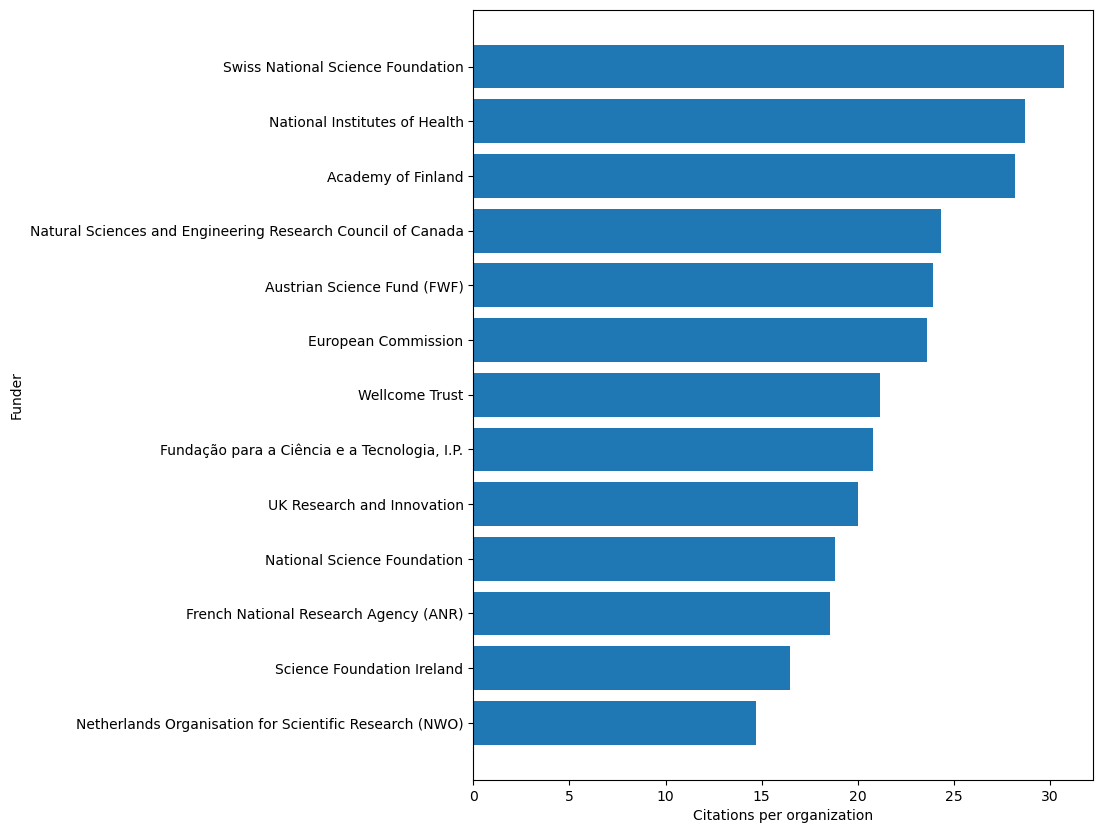

In [102]:
orgs = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(orgs[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Citations per organization')
plt.ylabel('Funder')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

### 2.3.6. Scientific impact characteristics

### 2.3.7. Scientific impact collaborations